In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg' # For mac users with Retina display

import numpy as np
import os
import matplotlib.pyplot as plt
import cPickle as pickle
import gzip
from photutils import CircularAnnulus
from photutils import CircularAperture
from photutils import aperture_photometry
from astropy.visualization import hist

from utils import *

In [5]:
# SPIRE channels
lambdas = [90, 250, 350, 500]
psf     = {250:17.8, 350:24.0, 500:35.2} # in arcsec 
factor  = {250:469./36., 350:831./64., 500:1804./144.} # Jy/beam -> Jy/pixel 
reso    = {250:6., 350:8., 500:12.} # in arcsec 
positions = {250: (25.5, 25.5), 350: (19.5,19.5), 500:(13.5,13.5), 90:(20,20)}
boxsize = {250:51, 350:39, 500:27, 90:40}

# H-ATLAS patches
patches = ['G9', 'G12', 'G15']#, 'NGP', 'SGP']

# Results folder
results_folder = 'results/'

zbins = [(1.,2.15), (2.15,2.50),(2.50,5.0)]
# zbins = [(0.1, 1.), (1.,2.), (2.,3.), (3.,4.)]#, (4.,5.)]

rmax = 9

extras_names = [
    'Z',
    'JMAG',			 # J magnitude 2MASS
    'ERR_JMAG',		 # Error J magnitude 2MASS
    'HMAG',			 # H magnitude 2MASS
    'ERR_HMAG',		 # Error H magnitude 2MASS
    'KMAG',			 # K magnitude 2MASS
    'ERR_KMAG',		 # Error K magnitude 2MASS
    'W1MAG',		 # w1 magnitude WISE
    'ERR_W1MAG',     # Error w1 magnitude WISE
    'W2MAG',		 # w2 magnitude WISE
    'ERR_W2MAG',     # Error w1 magnitude WISE
    'W3MAG',		 # w3 magnitude WISE
    'ERR_W3MAG',     # Error w1 magnitude WISE
    'W4MAG',		 # w4 magnitude WISE
    'ERR_W4MAG',     # Error w1 magnitude WISE
    'CC_FLAGS',     # WISE contamination and confusion flag
    'UKIDSS_MATCHED',# UKIDSS matched
    'YFLUX',         # Y-band flux density [Jy]
    'YFLUX_ERR',     # Error in Y-band density flux [Jy]
    'JFLUX',         # J-band flux density [Jy]
    'JFLUX_ERR',     # Error in J-band density flux [Jy]
    'HFLUX',         # H-band flux density [Jy]
    'HFLUX_ERR',     # Error in H-band density flux [Jy]
    'KFLUX',         # K-band flux density [Jy]
    'KFLUX_ERR',     # Error in K-band density flux [Jy]
    'PSFFLUX_U',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies] 
    'PSFFLUX_G',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies] 
    'PSFFLUX_R',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies] 
    'PSFFLUX_I',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies] 
    'PSFFLUX_Z',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies] 
    'IVAR_PSFFLUX_U',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_G',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_R',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_I',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_Z',  # Inverse variance of ugriz fluxes
    'EXTINCTION_U',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)      
    'EXTINCTION_G',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)      
    'EXTINCTION_R',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)      
    'EXTINCTION_I',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)      
    'EXTINCTION_Z',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)      
    'EXTINCTION_RECAL_U', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)      
    'EXTINCTION_RECAL_G', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)      
    'EXTINCTION_RECAL_R', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)      
    'EXTINCTION_RECAL_I', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)      
    'EXTINCTION_RECAL_Z', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)      
    'FLUX02_12KEV',     # Total flux (0.2 - 12 keV) XMM [erg/cm^2/s]
    'ERR_FLUX02_12KEV', # Error in total flux (0.2 - 12 keV) XMM [erg/cm^2/s]
    'FLUX02_2KEV',      # Soft flux (0.2 - 2 keV) XMM [erg/cm^2/s]
    'ERR_FLUX02_2KEV',  # Error in soft flux (0.2 - 2 keV) XMM [erg/cm^2/s]
    'FLUX2_12KEV',      # Hard flux (2 - 12 keV) XMM [erg/cm^2/s]
    'ERR_FLUX2_12KEV',  # Error in hard flux (2 - 12 keV) XMM [erg/cm^2/s]
    'LUM05_2KEV',       # Soft X-ray luminostiy [erg/s]
    'LUM2_12KEV',       # Hard X-ray luminostiy [erg/s]
    'LUM02_2KEV'        # Total X-ray luminostiy [erg/s]
    ]


In [6]:
anal = CutoutAnalysis('results/', zbins=[(1.,2.15), (2.15,2.50),(2.50,5.0)], extras_names=extras_names, lambdas=lambdas)

utils.py:636: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  cuts_id = np.random.choice(np.arange(simuls.shape[0]), size=simuls.shape[0]/nboot)
utils.py:687: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  cuts_id = np.random.choice(ncuts, size=ncuts/nboot)


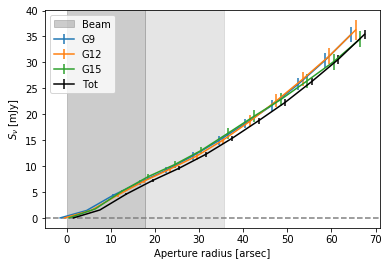

In [5]:
err9   = [anal.GetBootstrapErrs(250, 'G9',  0, r, remove_max=15, nsim=100) for r in np.arange(12)]
err12  = [anal.GetBootstrapErrs(250, 'G12', 0, r, remove_max=15, nsim=100) for r in np.arange(12)]
err15  = [anal.GetBootstrapErrs(250, 'G15', 0, r, remove_max=15, nsim=100) for r in np.arange(12)]
errTot = [anal.GetTotBootstrapErrs(250, 0, r, remove_max=15, nsim=100) for r in np.arange(12)]

plt.errorbar(reso[250]*np.arange(12)-1.5, [anal.GetPhotometryFromStacks(250, 'G9',  0, r, remove_max=15) for r in np.arange(12)], yerr=err9, label='G9')
plt.errorbar(reso[250]*np.arange(12)-0.5, [anal.GetPhotometryFromStacks(250, 'G12', 0, r, remove_max=15) for r in np.arange(12)], yerr=err12, label='G12')
plt.errorbar(reso[250]*np.arange(12)+0.5, [anal.GetPhotometryFromStacks(250, 'G15', 0, r, remove_max=15) for r in np.arange(12)], yerr=err15, label='G15')
plt.errorbar(reso[250]*np.arange(12)+1.5, [anal.GetTotPhotometryFromStacks(250, 0, r, remove_max=15) for r in np.arange(12)], yerr=errTot, label='Tot', color='k')

plt.axvspan(0, psf[250], alpha=0.4, color='grey', label=r'Beam')
plt.axvspan(psf[250], 2*psf[250], alpha=0.2, color='grey')
plt.axhline(ls='--', color='grey')

plt.legend()

plt.xlabel(r'Aperture radius [arsec]')
plt.ylabel(r'$S_{\nu}$ [mJy]')

Parameter('amplitude', value=2.91745174673)


<Gaussian2D(amplitude=2.917451746728246, x_mean=19.539378411381495, y_mean=19.423519412874786, x_stddev=1.22196762851215, y_stddev=1.37620616432904, theta=1.1143153707910112)>

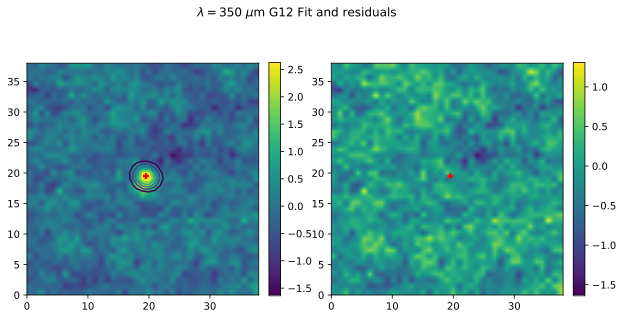

In [4]:
p = anal.GaussFit(350, 'G12', 2, remove_max=15, remove_mean=True, plot=True)
p

In [9]:
anal.FitGauss2D(350, 'G12', 2, remove_max=15)

2.94816309607


(array([  2.9481631 ,  19.53977066,  19.42266007,   1.41504783,
          1.2723502 ,   0.44485782,   0.92888709]),
 array([[  5.29309992e-02,  -1.04757903e-08,   8.76356433e-08,
          -1.26965279e-02,  -1.14202084e-02,  -1.63073395e-06,
           5.70317780e-09],
        [ -1.04757903e-08,   1.17507254e-02,  -9.03912911e-04,
           2.57652511e-09,   7.25171937e-09,  -1.87985074e-09,
          -8.69477559e-11],
        [  8.76356433e-08,  -9.03912911e-04,   1.02862759e-02,
          -1.76094033e-08,  -5.53136680e-08,  -2.07371040e-07,
           5.74399128e-10],
        [ -1.26965279e-02,   2.57652511e-09,  -1.76094033e-08,
           1.22752129e-02,   8.40831177e-05,   1.34779839e-07,
          -9.72924098e-05],
        [ -1.14202084e-02,   7.25171937e-09,  -5.53136680e-08,
           8.40831177e-05,   9.93106326e-03,   1.21320048e-06,
          -8.75118000e-05],
        [ -1.63073395e-06,  -1.87985074e-09,  -2.07371040e-07,
           1.34779839e-07,   1.21320048e-06,   2.70

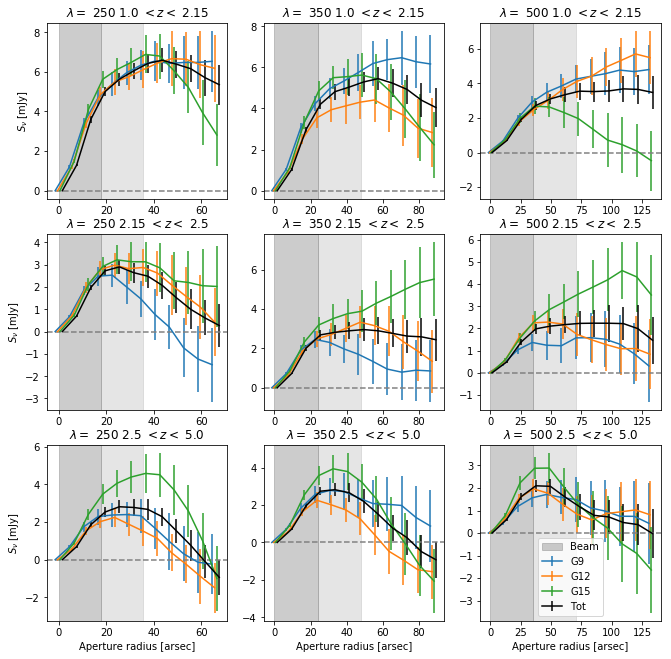

In [22]:
rmax = 12
nsim = 100

i = 1 
plt.figure(figsize=(11,11))
for idz, zbin in enumerate(zbins):
    for lambda_ in lambdas:
        plt.subplot(3,3,i)
        plt.title(r'$\lambda=$ '+str(lambda_) +' '+ str(zbin[0]) + r' $ < z < $ '+ str(zbin[1]))
        
        err9   = [anal.GetBootstrapErrs(lambda_, 'G9',  idz, r, remove_max=15, nsim=nsim) for r in np.arange(rmax)]
        err12  = [anal.GetBootstrapErrs(lambda_, 'G12', idz, r, remove_max=15, nsim=nsim) for r in np.arange(rmax)]
        err15  = [anal.GetBootstrapErrs(lambda_, 'G15', idz, r, remove_max=15, nsim=nsim) for r in np.arange(rmax)]
        errTot = [anal.GetTotBootstrapErrs(lambda_, idz, r, remove_max=15, nsim=nsim) for r in np.arange(rmax)]

        plt.errorbar(reso[lambda_]*np.arange(rmax)-1.5, [anal.GetPhotometryFromStacks(lambda_, 'G9',  idz, r, remove_max=15) for r in np.arange(rmax)], yerr=err9, label='G9')
        plt.errorbar(reso[lambda_]*np.arange(rmax)-0.5, [anal.GetPhotometryFromStacks(lambda_, 'G12', idz, r, remove_max=15) for r in np.arange(rmax)], yerr=err12, label='G12')
        plt.errorbar(reso[lambda_]*np.arange(rmax)+0.5, [anal.GetPhotometryFromStacks(lambda_, 'G15', idz, r, remove_max=15) for r in np.arange(rmax)], yerr=err15, label='G15')
        plt.errorbar(reso[lambda_]*np.arange(rmax)+1.5, [anal.GetTotPhotometryFromStacks(lambda_, idz, r, remove_max=15) for r in np.arange(rmax)], yerr=errTot, label='Tot', color='k')

        plt.axvspan(0, psf[lambda_], alpha=0.4, color='grey', label=r'Beam')
        plt.axvspan(psf[lambda_], 2*psf[lambda_], alpha=0.2, color='grey')
        plt.axhline(ls='--', color='grey')

        if i == 9:
            plt.legend()

        if i > 6:
            plt.xlabel(r'Aperture radius [arsec]')
        if i == 1 or i == 4 or i == 7:
            plt.ylabel(r'$S_{\nu}$ [mJy]')
        i += 1

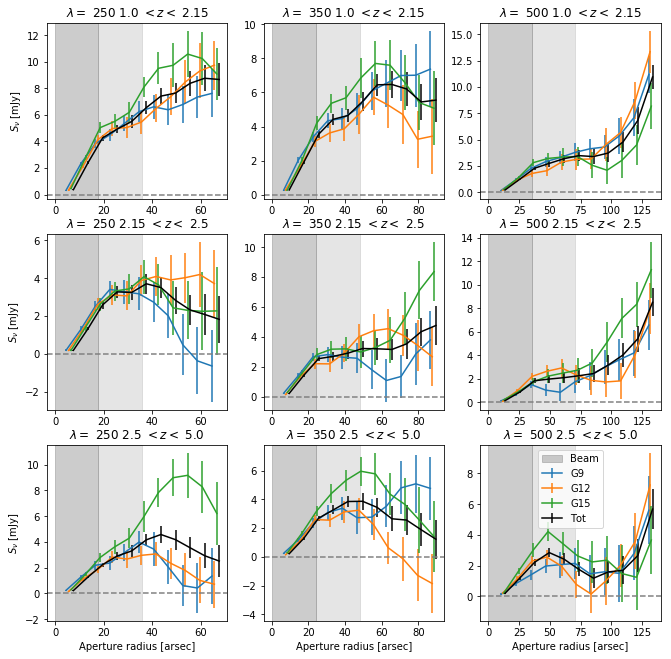

In [27]:
rmax = 12
nsim = 100

i = 1 
plt.figure(figsize=(11,11))
for idz, zbin in enumerate(zbins):
    for lambda_ in lambdas:
        plt.subplot(3,3,i)
        plt.title(r'$\lambda=$ '+str(lambda_) +' '+ str(zbin[0]) + r' $ < z < $ '+ str(zbin[1]))
        
        err9   = [anal.GetBootstrapErrs(lambda_, 'G9',  idz, r, r_in=r, r_out=np.sqrt(2)*r, remove_mean=False, remove_max=15, nsim=nsim) for r in np.arange(1,rmax)]
        err12  = [anal.GetBootstrapErrs(lambda_, 'G12', idz, r, r_in=r, r_out=np.sqrt(2)*r, remove_mean=False, remove_max=15, nsim=nsim) for r in np.arange(1,rmax)]
        err15  = [anal.GetBootstrapErrs(lambda_, 'G15', idz, r, r_in=r, r_out=np.sqrt(2)*r, remove_mean=False, remove_max=15, nsim=nsim) for r in np.arange(1,rmax)]
        errTot = [anal.GetTotBootstrapErrs(lambda_, idz, r, r_in=r, r_out=np.sqrt(2)*r, remove_mean=False, remove_max=15, nsim=nsim) for r in np.arange(1,rmax)]

        plt.errorbar(reso[lambda_]*np.arange(1,rmax)-1.5, [anal.GetPhotometryFromStacks(lambda_, 'G9',  idz, r, r_in=r, r_out=np.sqrt(2)*r, remove_mean=False, remove_max=15) for r in np.arange(1,rmax)], yerr=err9, label='G9')
        plt.errorbar(reso[lambda_]*np.arange(1,rmax)-0.5, [anal.GetPhotometryFromStacks(lambda_, 'G12', idz, r, r_in=r, r_out=np.sqrt(2)*r, remove_mean=False, remove_max=15) for r in np.arange(1,rmax)], yerr=err12, label='G12')
        plt.errorbar(reso[lambda_]*np.arange(1,rmax)+0.5, [anal.GetPhotometryFromStacks(lambda_, 'G15', idz, r, r_in=r, r_out=np.sqrt(2)*r, remove_mean=False, remove_max=15) for r in np.arange(1,rmax)], yerr=err15, label='G15')
        plt.errorbar(reso[lambda_]*np.arange(1,rmax)+1.5, [anal.GetTotPhotometryFromStacks(lambda_, idz, r, r_in=r, r_out=np.sqrt(2)*r, remove_mean=False, remove_max=15) for r in np.arange(1,rmax)], yerr=errTot, label='Tot', color='k')

        plt.axvspan(0, psf[lambda_], alpha=0.4, color='grey', label=r'Beam')
        plt.axvspan(psf[lambda_], 2*psf[lambda_], alpha=0.2, color='grey')
        plt.axhline(ls='--', color='grey')

        if i == 9:
            plt.legend()

        if i > 6:
            plt.xlabel(r'Aperture radius [arsec]')
        if i == 1 or i == 4 or i == 7:
            plt.ylabel(r'$S_{\nu}$ [mJy]')
        i += 1

In [4]:
## 2D Gaussian Fit - frequency & zbins

250 1.0 2.15 6.01955061834
350 1.0 2.15 4.78370588163
500 1.0 2.15 3.04457259032
250 2.15 2.5 3.39603415897
350 2.15 2.5 3.52919639407
500 2.15 2.5 2.24676119972
250 2.5 5.0 3.2779291061
350 2.5 5.0 3.46147621207
500 2.5 5.0 2.95961339692


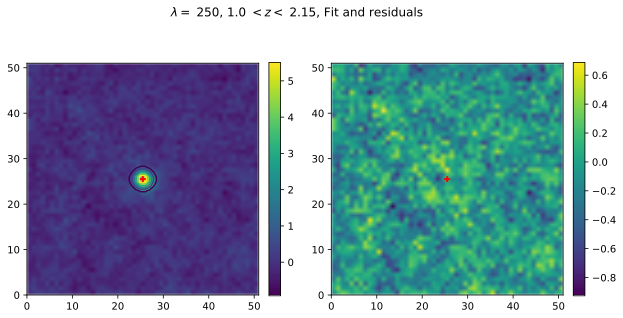

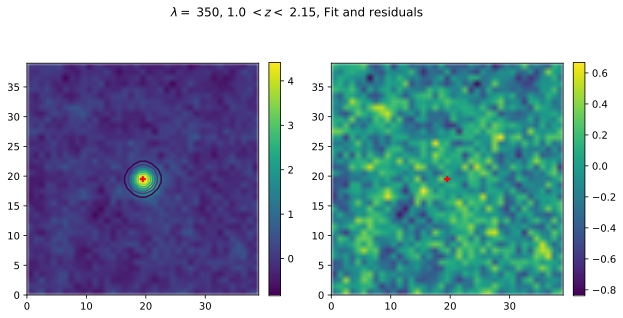

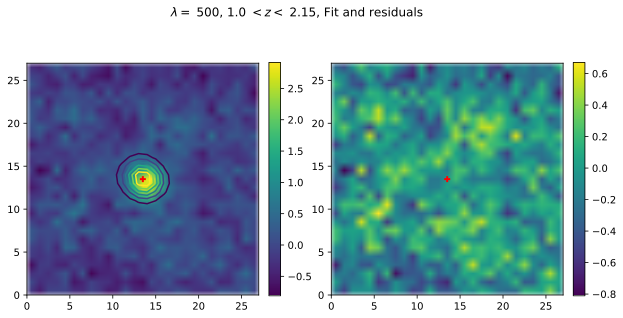

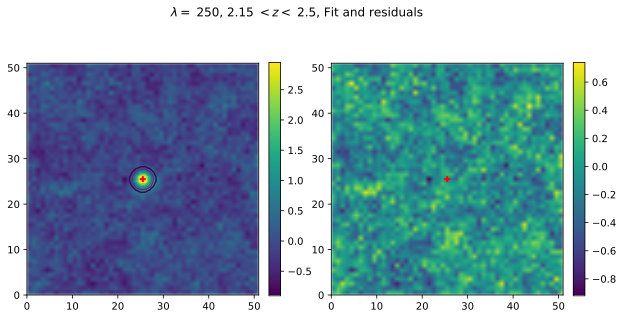

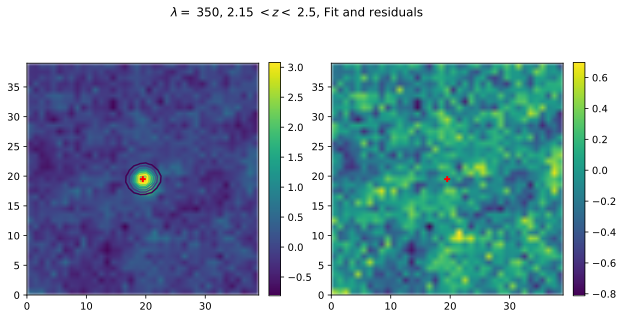

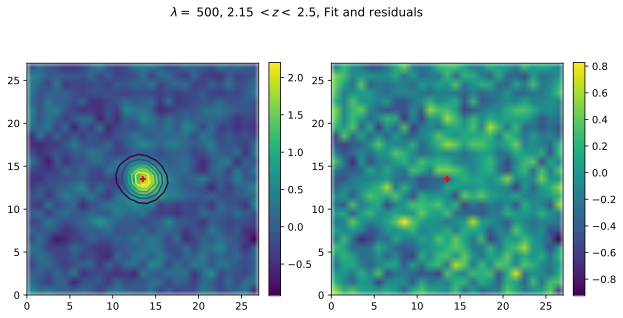

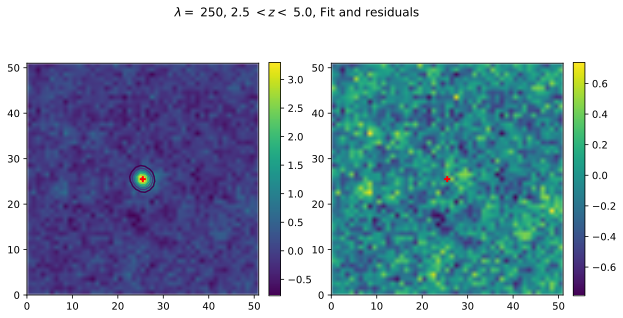

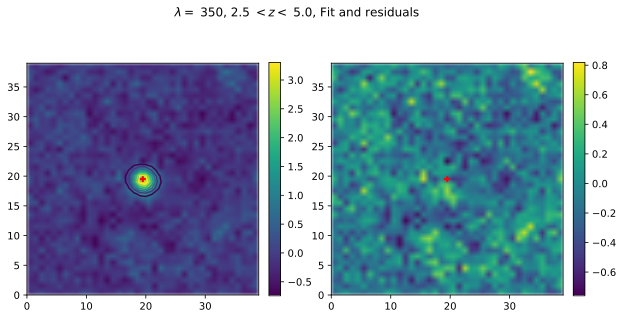

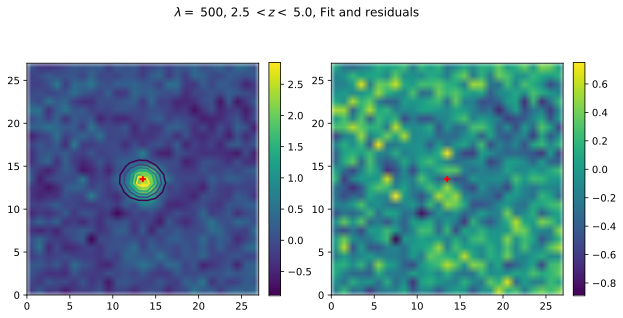

In [5]:
for idz, zbin in enumerate(zbins):
    for lambda_ in lambdas:
            p = anal.GaussFitTot(lambda_, idz, remove_max=15, remove_mean=True, plot=True)
            print lambda_, zbin[0], zbin[1], p.amplitude.value

In [7]:
## 2D Gaussian Fit - frequency 

250 4.23309124567
350 3.9174624163
500 2.74705968495


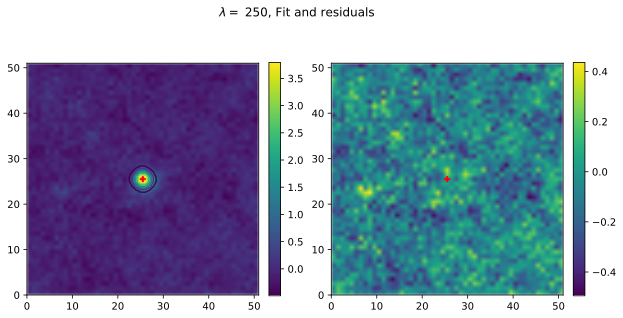

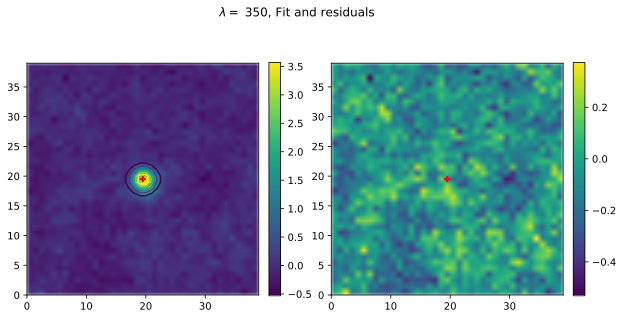

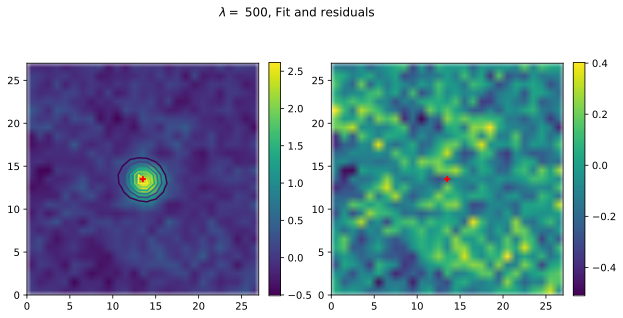

In [6]:
for lambda_ in lambdas:
        p = anal.GaussFitTotZ(lambda_, remove_max=15, remove_mean=True, plot=True)
        print lambda_, p.amplitude.value

In [7]:
for idz, zbin in enumerate(zbins):
    for lambda_ in lambdas:
            err = anal.GetTotBootstrapErrsFit2D(lambda_, idz, remove_mean=True, remove_max=15, nsim=500, nboot=2.)
            print lambda_, zbin[0], zbin[1], err

utils.py:412: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  cuts_id = np.random.choice(ncuts, size=ncuts/nboot)


250 1.0 2.15 0.261859591402
350 1.0 2.15 0.239529845451
500 1.0 2.15 0.224142437651
250 2.15 2.5 0.207894999607
350 2.15 2.5 0.225625986682


500 2.15 2.5 0.213102174562
250 2.5 5.0 0.240425047905
350 2.5 5.0 0.240222600162
500 2.5 5.0 0.22941373215


In [9]:
for lambda_ in lambdas:
        err = anal.GetTotZBootstrapErrsFit2D(lambda_, remove_mean=True, remove_max=15, nsim=500, nboot=2.)
        print lambda_, err

utils.py:445: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  cuts_id = np.random.choice(ncuts, size=ncuts/nboot)


250 0.134121031337
350 0.138082427135
500 0.130001206145


In [8]:
## Fluxes WISE ##

In [9]:
w1mag = np.concatenate([anal.extras[350][patch][idz]['W1MAG'].copy() for patch in patches for idz in xrange(len(zbins))], axis=0)
w2mag = np.concatenate([anal.extras[350][patch][idz]['W2MAG'].copy() for patch in patches for idz in xrange(len(zbins))], axis=0)
w3mag = np.concatenate([anal.extras[350][patch][idz]['W3MAG'].copy() for patch in patches for idz in xrange(len(zbins))], axis=0)
w4mag = np.concatenate([anal.extras[350][patch][idz]['W4MAG'].copy() for patch in patches for idz in xrange(len(zbins))], axis=0)

errw1mag = np.concatenate([anal.extras[350][patch][idz]['ERR_W1MAG'].copy() for patch in patches for idz in xrange(len(zbins))], axis=0)
errw2mag = np.concatenate([anal.extras[350][patch][idz]['ERR_W2MAG'].copy() for patch in patches for idz in xrange(len(zbins))], axis=0)
errw3mag = np.concatenate([anal.extras[350][patch][idz]['ERR_W3MAG'].copy() for patch in patches for idz in xrange(len(zbins))], axis=0)
errw4mag = np.concatenate([anal.extras[350][patch][idz]['ERR_W4MAG'].copy() for patch in patches for idz in xrange(len(zbins))], axis=0)

ccflag = np.concatenate([anal.extras[350][patch][idz]['CC_FLAGS'].copy() for patch in patches for idz in xrange(len(zbins))], axis=0)


15.9102521331
15.765513463 14.5494849835
10.7289516921
8.02653365593
[ 17.529  16.932  16.505 ...,  15.863  17.173  17.618]


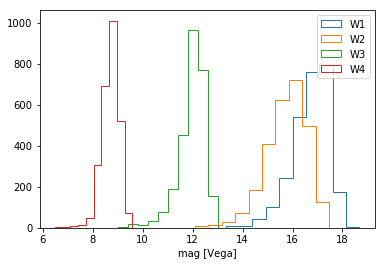

In [10]:
print np.sum(w1mag[ccflag=='0000']/errw1mag[ccflag=='0000']**2)/np.sum(1./errw1mag[ccflag=='0000']**2)
print np.mean(w2mag[ccflag=='0000']) , np.sum(w2mag[ccflag=='0000']/errw2mag[ccflag=='0000']**2)/np.sum(1./errw2mag[ccflag=='0000']**2)
print np.sum(w3mag[ccflag=='0000']/errw3mag[ccflag=='0000']**2)/np.sum(1./errw3mag[ccflag=='0000']**2)
print np.sum(w4mag[ccflag=='0000']/errw4mag[ccflag=='0000']**2)/np.sum(1./errw4mag[ccflag=='0000']**2)

print w1mag[ccflag=='0000']
hist(w1mag[ccflag=='0000'], histtype='step', label='W1')
hist(w2mag[ccflag=='0000'], histtype='step', label='W2')
hist(w3mag[ccflag=='0000'], histtype='step', label='W3')
hist(w4mag[ccflag=='0000'], histtype='step', label='W4')

plt.legend()

plt.xlabel('mag [Vega]')



(452,)
(452,)
(452,)
(452,)

(1156,)
(1156,)
(1156,)
(1156,)

(1066,)
(1066,)
(1066,)
(1066,)


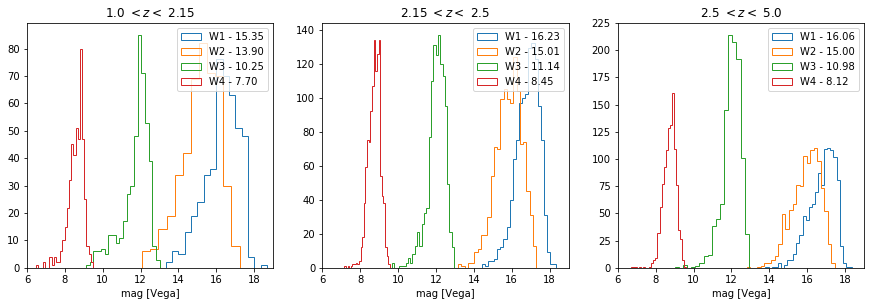

In [11]:
i = 1
plt.figure(figsize=(15,4.5))
for idz, zbin in enumerate(zbins):
    plt.subplot(1,3,i)
    plt.title(str(zbin[0]) + r' $ < z < $ '+ str(zbin[1]))

    w1mag = np.concatenate([anal.extras[350][patch][idz]['W1MAG'].copy() for patch in patches], axis=0)
    w2mag = np.concatenate([anal.extras[350][patch][idz]['W2MAG'].copy() for patch in patches], axis=0)
    w3mag = np.concatenate([anal.extras[350][patch][idz]['W3MAG'].copy() for patch in patches], axis=0)
    w4mag = np.concatenate([anal.extras[350][patch][idz]['W4MAG'].copy() for patch in patches], axis=0)
    
#     w1mag = np.concatenate([anal.extras[350][patch][idz]['W1MAG'].copy() for patch in patches], axis=0)
#     w2mag = np.concatenate([anal.extras[350][patch][idz]['W2MAG'].copy() for patch in patches], axis=0)
#     w3mag = np.concatenate([anal.extras[350][patch][idz]['W3MAG'].copy() for patch in patches], axis=0)
#     w4mag = np.concatenate([anal.extras[350][patch][idz]['W4MAG'].copy() for patch in patches], axis=0)

    errw1mag = np.concatenate([anal.extras[350][patch][idz]['ERR_W1MAG'].copy() for patch in patches], axis=0)
    errw2mag = np.concatenate([anal.extras[350][patch][idz]['ERR_W2MAG'].copy() for patch in patches], axis=0)
    errw3mag = np.concatenate([anal.extras[350][patch][idz]['ERR_W3MAG'].copy() for patch in patches], axis=0)
    errw4mag = np.concatenate([anal.extras[350][patch][idz]['ERR_W4MAG'].copy() for patch in patches], axis=0)

    ccflag = np.concatenate([anal.extras[350][patch][idz]['CC_FLAGS'].copy() for patch in patches], axis=0)

    mean1 = np.sum(w1mag[ccflag=='0000']/errw1mag[ccflag=='0000']**2)/np.sum(1./errw1mag[ccflag=='0000']**2)
    mean2 = np.sum(w2mag[ccflag=='0000']/errw2mag[ccflag=='0000']**2)/np.sum(1./errw2mag[ccflag=='0000']**2)
    mean3 = np.sum(w3mag[ccflag=='0000']/errw3mag[ccflag=='0000']**2)/np.sum(1./errw3mag[ccflag=='0000']**2)
    mean4 = np.sum(w4mag[ccflag=='0000']/errw4mag[ccflag=='0000']**2)/np.sum(1./errw4mag[ccflag=='0000']**2)
    print ''
    i += 1

    hist(w1mag[ccflag=='0000'], bins='knuth', histtype='step', label='W1 - %.2f' %mean1)
    hist(w2mag[ccflag=='0000'], bins='knuth', histtype='step', label='W2 - %.2f' %mean2)
    hist(w3mag[ccflag=='0000'], bins='knuth', histtype='step', label='W3 - %.2f' %mean3)
    hist(w4mag[ccflag=='0000'], bins='knuth', histtype='step', label='W4 - %.2f' %mean4)

    print w1mag[ccflag=='0000'].shape
    print w2mag[ccflag=='0000'].shape
    print w3mag[ccflag=='0000'].shape
    print w4mag[ccflag=='0000'].shape
    
    plt.xlim([6,19])
    plt.legend()
    plt.xlabel('mag [Vega]')
    
# print np.sum(w4mag[ccflag=='0000']/errw4mag[ccflag=='0000']**2)/np.sum(1./errw4mag[ccflag=='0000']**2)


0.17018232546
0.320090127146
0.899372870786
1.79014668882

0.051707544605
0.0816499913519
0.339218582286
0.912826712959

0.0666671369865
0.0842292284696
0.434593145823
1.11066613386


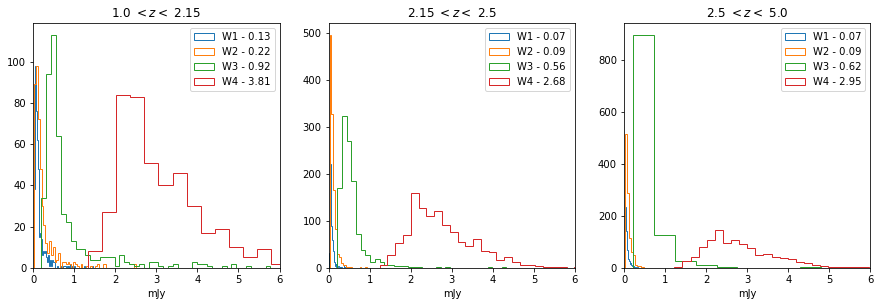

In [106]:
# Vega Mag 2 mJy

i = 1
plt.figure(figsize=(15,4.5))
for idz, zbin in enumerate(zbins):
    plt.subplot(1,3,i)
    plt.title(str(zbin[0]) + r' $ < z < $ '+ str(zbin[1]))

    w1mag = WISEMag2mJy(np.concatenate([anal.extras[350][patch][idz]['W1MAG'].copy() for patch in patches], axis=0), W='W1')
    w2mag = WISEMag2mJy(np.concatenate([anal.extras[350][patch][idz]['W2MAG'].copy() for patch in patches], axis=0), W='W2')
    w3mag = WISEMag2mJy(np.concatenate([anal.extras[350][patch][idz]['W3MAG'].copy() for patch in patches], axis=0), W='W3')
    w4mag = WISEMag2mJy(np.concatenate([anal.extras[350][patch][idz]['W4MAG'].copy() for patch in patches], axis=0), W='W4')

    errw1mag = WISEMag2mJy(np.concatenate([anal.extras[350][patch][idz]['ERR_W1MAG'].copy() for patch in patches], axis=0), W='W1')
    errw2mag = WISEMag2mJy(np.concatenate([anal.extras[350][patch][idz]['ERR_W2MAG'].copy() for patch in patches], axis=0), W='W2')
    errw3mag = WISEMag2mJy(np.concatenate([anal.extras[350][patch][idz]['ERR_W3MAG'].copy() for patch in patches], axis=0), W='W3')
    errw4mag = WISEMag2mJy(np.concatenate([anal.extras[350][patch][idz]['ERR_W4MAG'].copy() for patch in patches], axis=0), W='W4')

    ccflag = np.concatenate([anal.extras[350][patch][idz]['CC_FLAGS'].copy() for patch in patches], axis=0)

    mean1 = np.sum(w1mag[ccflag=='0000']/errw1mag[ccflag=='0000']**2)/np.sum(1./errw1mag[ccflag=='0000']**2)
    mean2 = np.sum(w2mag[ccflag=='0000']/errw2mag[ccflag=='0000']**2)/np.sum(1./errw2mag[ccflag=='0000']**2)
    mean3 = np.sum(w3mag[ccflag=='0000']/errw3mag[ccflag=='0000']**2)/np.sum(1./errw3mag[ccflag=='0000']**2)
    mean4 = np.sum(w4mag[ccflag=='0000']/errw4mag[ccflag=='0000']**2)/np.sum(1./errw4mag[ccflag=='0000']**2)
    print ''
    i += 1

    hist(w1mag[ccflag=='0000'], bins='knuth', histtype='step', label='W1 - %.2f' %mean1)
    hist(w2mag[ccflag=='0000'], bins='knuth', histtype='step', label='W2 - %.2f' %mean2)
    hist(w3mag[ccflag=='0000'], bins='knuth', histtype='step', label='W3 - %.2f' %mean3)
    hist(w4mag[ccflag=='0000'], bins='knuth', histtype='step', label='W4 - %.2f' %mean4)

    print np.std(w1mag[ccflag=='0000'])
    print np.std(w2mag[ccflag=='0000'])
    print np.std(w3mag[ccflag=='0000'])
    print np.std(w4mag[ccflag=='0000'])
#     print w1mag[ccflag=='0000'].shape
#     print w2mag[ccflag=='0000'].shape
#     print w3mag[ccflag=='0000'].shape
#     print w4mag[ccflag=='0000'].shape
    
    plt.xlim([0,6])
    plt.legend()
    plt.xlabel('mJy')
    
# print np.sum(w4mag[ccflag=='0000']/errw4mag[ccflag=='0000']**2)/np.sum(1./errw4mag[ccflag=='0000']**2)

In [11]:
anal.GetFluxesCats('WISE')

utils.py:43: RuntimeWarning: overflow encountered in double_scalars
  return 171.787 * 10**(-mags/2.5) * 1e3
utils.py:45: RuntimeWarning: overflow encountered in double_scalars
  return 31.674 * 10**(-mags/2.5) * 1e3
utils.py:47: RuntimeWarning: overflow encountered in double_scalars
  return 8.363 * 10**(-mags/2.5) * 1e3


In [12]:
anal.meanw3

{0: 0.91857981981534542,
 1: 0.5624002621959312,
 2: 0.61703578882999888,
 'all': 0.64583401494711035}

In [12]:
## Fluxes 2MASS ##


0.0893600478689
0.108353890258
0.117543459629

0.0885506714451
0.0859945672468
0.109048552719

0.114791946555
0.131308978032
0.0756014076582


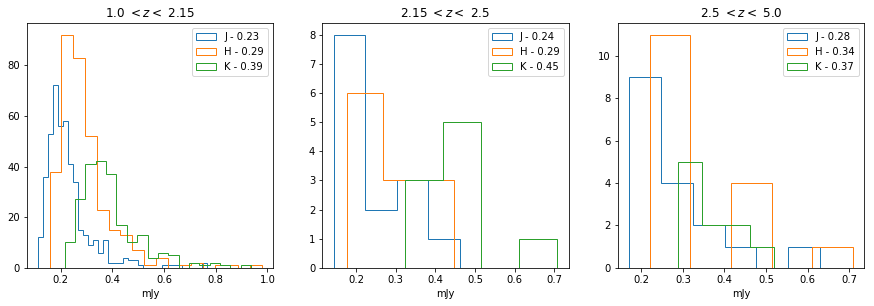

In [158]:
i = 1
plt.figure(figsize=(15,4.5))
for idz, zbin in enumerate(zbins):
    plt.subplot(1,3,i)
    
    jflag = np.where(np.concatenate([anal.extras[350][patch][idz]['JMAG'].copy() for patch in patches], axis=0)>0)
    hflag = np.where(np.concatenate([anal.extras[350][patch][idz]['HMAG'].copy() for patch in patches], axis=0)>0)
    kflag = np.where(np.concatenate([anal.extras[350][patch][idz]['KMAG'].copy() for patch in patches], axis=0)>0)
    
    plt.title(str(zbin[0]) + r' $ < z < $ '+ str(zbin[1]))
    jmag = TwoMASSMag2mJy(np.concatenate([anal.extras[350][patch][idz]['JMAG'].copy() for patch in patches], axis=0), W='J')
    hmag = TwoMASSMag2mJy(np.concatenate([anal.extras[350][patch][idz]['HMAG'].copy() for patch in patches], axis=0), W='H')
    kmag = TwoMASSMag2mJy(np.concatenate([anal.extras[350][patch][idz]['KMAG'].copy() for patch in patches], axis=0), W='K_S')

    errjmag = TwoMASSMag2mJy(np.concatenate([anal.extras[350][patch][idz]['ERR_JMAG'].copy() for patch in patches], axis=0), W='J')
    errhmag = TwoMASSMag2mJy(np.concatenate([anal.extras[350][patch][idz]['ERR_HMAG'].copy() for patch in patches], axis=0), W='H')
    errkmag = TwoMASSMag2mJy(np.concatenate([anal.extras[350][patch][idz]['ERR_KMAG'].copy() for patch in patches], axis=0), W='K_S')

    meanj = np.mean(jmag[jflag])#np.sum(jmag[jflag]/errjmag[jflag]**2)/np.sum(1./errjmag[jflag]**2)
    meanh = np.mean(hmag[hflag])#np.sum(hmag[hflag]/errhmag[hflag]**2)/np.sum(1./errhmag[hflag]**2)
    meank = np.mean(kmag[kflag])#np.sum(kmag[kflag]/errkmag[kflag]**2)/np.sum(1./errkmag[kflag]**2)
    print ''
    i += 1

    hist(jmag[jflag], bins='knuth', histtype='step', label='J - %.2f' %meanj)
    hist(hmag[hflag], bins='knuth', histtype='step', label='H - %.2f' %meanh)
    hist(kmag[kflag], bins='knuth', histtype='step', label='K - %.2f' %meank)

    print np.std(jmag[jflag])
    print np.std(hmag[hflag])
    print np.std(kmag[kflag])

#     print jmag[jflag].shape
#     print hmag[hflag].shape
#     print kmag[kflag].shape
    
#     plt.xlim([14,18])
    plt.legend()
    plt.xlabel('mJy')
    
# print np.sum(w4mag[ccflag=='0000']/errw4mag[ccflag=='0000']**2)/np.sum(1./errw4mag[ccflag=='0000']**2)

In [13]:
anal.GetFluxesCats('2MASS')

In [24]:
anal.meank

{0: 0.39113476013741966,
 1: 0.44930910439054195,
 2: 0.3664536865756855,
 'all': 0.39229761040070021}

In [ ]:
i = 1
plt.figure(figsize=(15,4.5))
for idz, zbin in enumerate(zbins):
    plt.subplot(1,3,i)
    plt.title(str(zbin[0]) + r' $ < z < $ '+ str(zbin[1]))
    jmag = np.concatenate([anal.extras[350][patch][idz]['JMAG'].copy() for patch in patches], axis=0)
    hmag = np.concatenate([anal.extras[350][patch][idz]['HMAG'].copy() for patch in patches], axis=0)
    kmag = np.concatenate([anal.extras[350][patch][idz]['KMAG'].copy() for patch in patches], axis=0)

    errjmag = np.concatenate([anal.extras[350][patch][idz]['ERR_JMAG'].copy() for patch in patches], axis=0)
    errhmag = np.concatenate([anal.extras[350][patch][idz]['ERR_HMAG'].copy() for patch in patches], axis=0)
    errkmag = np.concatenate([anal.extras[350][patch][idz]['ERR_KMAG'].copy() for patch in patches], axis=0)

    jflag = np.where(jmag>0)
    hflag = np.where(hmag>0)
    kflag = np.where(kmag>0)

    meanj = np.mean(jmag[jflag])#np.sum(jmag[jflag]/errjmag[jflag]**2)/np.sum(1./errjmag[jflag]**2)
    meanh = np.mean(hmag[hflag])#np.sum(hmag[hflag]/errhmag[hflag]**2)/np.sum(1./errhmag[hflag]**2)
    meank = np.mean(kmag[kflag])#np.sum(kmag[kflag]/errkmag[kflag]**2)/np.sum(1./errkmag[kflag]**2)
    print ''
    i += 1

    hist(jmag[jflag], bins='knuth', histtype='step', label='J - %.2f' %meanj)
    hist(hmag[hflag], bins='knuth', histtype='step', label='H - %.2f' %meanh)
    hist(kmag[kflag], bins='knuth', histtype='step', label='K - %.2f' %meank)

    print jmag[jflag].shape
    print hmag[hflag].shape
    print kmag[kflag].shape
    
    plt.xlim([14,18])
    plt.legend()
    plt.xlabel('mag [Vega]')
    
# print np.sum(w4mag[ccflag=='0000']/errw4mag[ccflag=='0000']**2)/np.sum(1./errw4mag[ccflag=='0000']**2)

In [41]:
ccflag = np.concatenate([anal.extras[350][patch][0]['CC_FLAGS'].copy() for patch in patches], axis=0)
ccflag

array(['nan', 'nan', 'nan', ..., '0000', '0000', '0000'], 
      dtype='|S32')

In [ ]:
## Fluxes UKIDSS ##`

In [47]:
WmHz2mJy = 1e29


0.0367206210647
0.0380956485395
0.0432265338659
0.046103326738

0.032266872168
0.0319881475805
0.0356538872156
0.0479429583798

0.0362469440729
0.0396899959864
0.040534519422
0.0444878598284


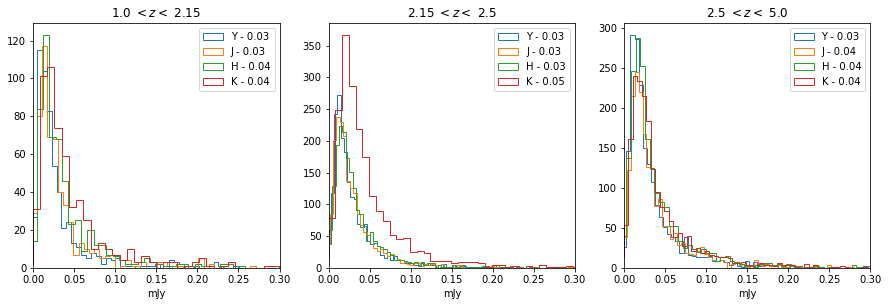

In [107]:
i = 1
plt.figure(figsize=(15,4.5))
for idz, zbin in enumerate(zbins):
    plt.subplot(1,3,i)
    plt.title(str(zbin[0]) + r' $ < z < $ '+ str(zbin[1]))
    
    yflux = np.concatenate([anal.extras[350][patch][idz]['YFLUX'].copy() for patch in patches], axis=0) * WmHz2mJy
    jflux = np.concatenate([anal.extras[350][patch][idz]['JFLUX'].copy() for patch in patches], axis=0) * WmHz2mJy
    hflux = np.concatenate([anal.extras[350][patch][idz]['HFLUX'].copy() for patch in patches], axis=0) * WmHz2mJy
    kflux = np.concatenate([anal.extras[350][patch][idz]['KFLUX'].copy() for patch in patches], axis=0) * WmHz2mJy
    
    erryflux = np.concatenate([anal.extras[350][patch][idz]['YFLUX_ERR'].copy() for patch in patches], axis=0) * WmHz2mJy
    errjflux = np.concatenate([anal.extras[350][patch][idz]['JFLUX_ERR'].copy() for patch in patches], axis=0) * WmHz2mJy
    errhflux = np.concatenate([anal.extras[350][patch][idz]['HFLUX_ERR'].copy() for patch in patches], axis=0) * WmHz2mJy
    errkflux = np.concatenate([anal.extras[350][patch][idz]['KFLUX_ERR'].copy() for patch in patches], axis=0) * WmHz2mJy

    flag = np.concatenate([anal.extras[350][patch][idz]['UKIDSS_MATCHED'].copy() for patch in patches], axis=0)

    meany = np.mean(yflux[flag==1])#np.sum(yflux[flag==1]/erryflux[flag==1]**2)/np.sum(1./erryflux[flag==1]**2)
    meanj = np.mean(jflux[flag==1])#np.sum(jflux[flag==1]/errjflux[flag==1]**2)/np.sum(1./errjflux[flag==1]**2)
    meanh = np.mean(hflux[flag==1])#np.sum(hflux[flag==1]/errhflux[flag==1]**2)/np.sum(1./errhflux[flag==1]**2)
    meank = np.mean(kflux[flag==1])#np.sum(kflux[flag==1]/errkflux[flag==1]**2)/np.sum(1./errkflux[flag==1]**2)
    
    print ''
    i += 1

    hist(yflux[flag==1], bins='knuth', histtype='step', label='Y - %.2f' %meany)
    hist(jflux[flag==1], bins='knuth', histtype='step', label='J - %.2f' %meanj)
    hist(hflux[flag==1], bins='knuth', histtype='step', label='H - %.2f' %meanh)
    hist(kflux[flag==1], bins='knuth', histtype='step', label='K - %.2f' %meank)

    print np.std(yflux[flag==1])
    print np.std(jflux[flag==1])
    print np.std(hflux[flag==1])
    print np.std(kflux[flag==1])
    
#     print yflux[flag==1].shape
#     print jflux[flag==1].shape
#     print hflux[flag==1].shape
#     print kflux[flag==1].shape
    
    plt.xlim([0,.3])
    plt.legend()
    plt.xlabel('mJy')
    
# print np.sum(w4mag[ccflag=='0000']/errw4mag[ccflag=='0000']**2)/np.sum(1./errw4mag[ccflag=='0000']**2)

In [44]:
yflux[flag==1]*13

array([  4.24280190e-30,   1.34388410e-30,   2.84092264e-30, ...,
         1.72293463e-29,   2.81887276e-30,   2.77990879e-30])

In [15]:
anal.GetFluxesCats('ukidss')

In [20]:
print np.percentile(anal.yfluxUKIDSS[0], 14)
print np.percentile(anal.yfluxUKIDSS[0], 86)

0.00744068093481
0.0505150073674


In [17]:
anal.meanyUKIDSS

{0: 0.030402507551971873,
 1: 0.030968023632292584,
 2: 0.0347362118193223,
 'all': 0.032514943609925337}

In [ ]:
## Fluxes SDSS ##


0.0547494118176
0.0646230754362
0.0784392926743
0.0883765120305
0.0929380345616

0.0158575009381
0.0253893937295
0.0290045966372
0.031321938822
0.0386309030596

0.0121142327878
0.0260537947045
0.0316003522543
0.0359519037558
0.0417619570278


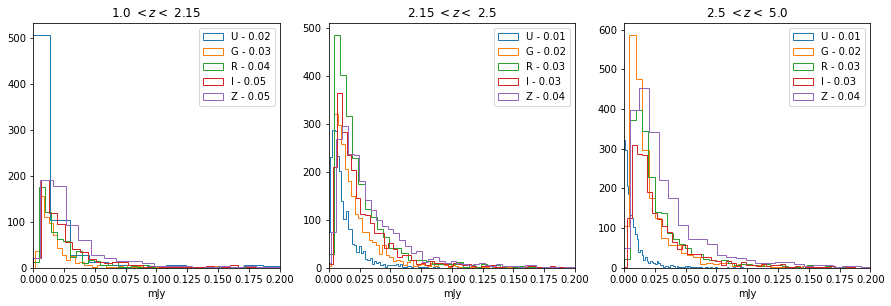

In [118]:
i = 1
plt.figure(figsize=(15,4.5))
for idz, zbin in enumerate(zbins):
    plt.subplot(1,3,i)
    plt.title(str(zbin[0]) + r' $ < z < $ '+ str(zbin[1]))
    
    flag = np.concatenate([~np.isnan(anal.extras[350][patch][idz]['PSFFLUX_Z']) for patch in patches], axis=0) 
    
    uflux = np.concatenate([anal.extras[350][patch][idz]['PSFFLUX_U'].copy() for patch in patches], axis=0) 
    gflux = np.concatenate([anal.extras[350][patch][idz]['PSFFLUX_G'].copy() for patch in patches], axis=0) 
    rflux = np.concatenate([anal.extras[350][patch][idz]['PSFFLUX_R'].copy() for patch in patches], axis=0) 
    iflux = np.concatenate([anal.extras[350][patch][idz]['PSFFLUX_I'].copy() for patch in patches], axis=0) 
    zflux = np.concatenate([anal.extras[350][patch][idz]['PSFFLUX_Z'].copy() for patch in patches], axis=0) 
    
    uflux -= np.concatenate([anal.extras[350][patch][idz]['EXTINCTION_U'].copy() for patch in patches], axis=0) 
    gflux -= np.concatenate([anal.extras[350][patch][idz]['EXTINCTION_G'].copy() for patch in patches], axis=0) 
    rflux -= np.concatenate([anal.extras[350][patch][idz]['EXTINCTION_R'].copy() for patch in patches], axis=0) 
    iflux -= np.concatenate([anal.extras[350][patch][idz]['EXTINCTION_I'].copy() for patch in patches], axis=0) 
    zflux -= np.concatenate([anal.extras[350][patch][idz]['EXTINCTION_Z'].copy() for patch in patches], axis=0)     
    
    erruflux = SDSSMag2mJy(np.concatenate([anal.extras[350][patch][idz]['IVAR_PSFFLUX_U'].copy() for patch in patches], axis=0)) 
    errgflux = SDSSMag2mJy(np.concatenate([anal.extras[350][patch][idz]['IVAR_PSFFLUX_G'].copy() for patch in patches], axis=0))
    errrflux = SDSSMag2mJy(np.concatenate([anal.extras[350][patch][idz]['IVAR_PSFFLUX_R'].copy() for patch in patches], axis=0))
    erriflux = SDSSMag2mJy(np.concatenate([anal.extras[350][patch][idz]['IVAR_PSFFLUX_I'].copy() for patch in patches], axis=0))
    errzflux = SDSSMag2mJy(np.concatenate([anal.extras[350][patch][idz]['IVAR_PSFFLUX_Z'].copy() for patch in patches], axis=0)) 

    meanu = np.mean(SDSSMag2mJy(uflux[flag]))#np.sum(yflux[flag==1]/erryflux[flag==1]**2)/np.sum(1./erryflux[flag==1]**2)
    meang = np.mean(SDSSMag2mJy(gflux[flag]))#np.sum(jflux[flag==1]/errjflux[flag==1]**2)/np.sum(1./errjflux[flag==1]**2)
    meanr = np.mean(SDSSMag2mJy(rflux[flag]))#np.sum(hflux[flag==1]/errhflux[flag==1]**2)/np.sum(1./errhflux[flag==1]**2)
    meani = np.mean(SDSSMag2mJy(iflux[flag]))#np.sum(kflux[flag==1]/errkflux[flag==1]**2)/np.sum(1./errkflux[flag==1]**2)
    meanz = np.mean(SDSSMag2mJy(zflux[flag]))#np.sum(kflux[flag==1]/errkflux[flag==1]**2)/np.sum(1./errkflux[flag==1]**2)
    
    print ''
    i += 1

    hist(SDSSMag2mJy(uflux[flag]), bins='knuth', histtype='step', label='U - %.2f' %meanu)
    hist(SDSSMag2mJy(gflux[flag]), bins='knuth', histtype='step', label='G - %.2f' %meang)
    hist(SDSSMag2mJy(rflux[flag]), bins='knuth', histtype='step', label='R - %.2f' %meanr)
    hist(SDSSMag2mJy(iflux[flag]), bins='knuth', histtype='step', label='I - %.2f' %meani)
    hist(SDSSMag2mJy(zflux[flag]), bins='knuth', histtype='step', label='Z - %.2f' %meanz)

#     print uflux[flag].shape
    print np.std(SDSSMag2mJy(uflux[flag]))
    print np.std(SDSSMag2mJy(gflux[flag]))
    print np.std(SDSSMag2mJy(rflux[flag]))
    print np.std(SDSSMag2mJy(iflux[flag]))
    print np.std(SDSSMag2mJy(zflux[flag]))
    
    plt.xlim([0,.2])
    plt.legend()
    plt.xlabel('mJy')
    
# print np.sum(w4mag[ccflag=='0000']/errw4mag[ccflag=='0000']**2)/np.sum(1./errw4mag[ccflag=='0000']**2)

In [97]:
anal.GetFluxesCats('SDSS')

In [70]:
anal.meanu

{0: 0.024710915961277054,
 1: 0.013291247407210721,
 2: 0.0070008739977955722,
 'all': 0.012205476750739439}

In [68]:
np.mean(anal.uflux[0])

0.024710915961277054

In [98]:
anal.meanu

{0: 0.02543683689324857,
 1: 0.014044313219680757,
 2: 0.0077311296117175375,
 'all': 0.01294522188913457}

In [72]:
(np.isnan(anal.extras[250]['G12'][0]['PSFFLUX_Z']) == np.isnan(anal.extras[250]['G12'][0]['PSFFLUX_G'])).all()

True

In [ ]:
## Luminosity XMM ##

/Users/fbianchini/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in greater
/Users/fbianchini/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
/Users/fbianchini/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater


8.76479000033e+44

(23,)
(23,)
(23,)
1.00805064452e+45

(44,)
(44,)
(44,)
1.24359986686e+45

(36,)
(36,)
(36,)


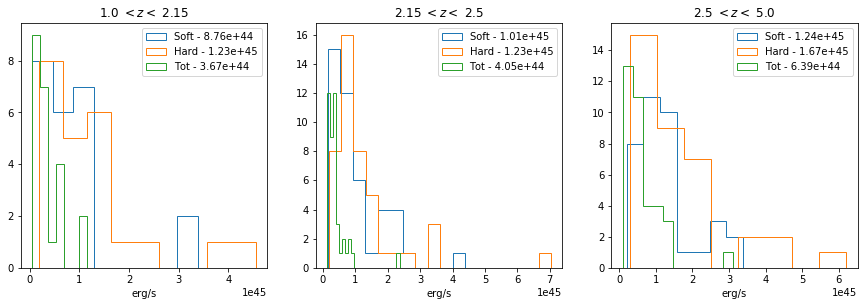

In [89]:
i = 1
plt.figure(figsize=(15,4.5))
for idz, zbin in enumerate(zbins):
    plt.subplot(1,3,i)
    plt.title(str(zbin[0]) + r' $ < z < $ '+ str(zbin[1]))
    
#     flagsoft = np.concatenate([~np.isnan(anal.extras[350][patch][idz]['LUM05_2KEV']) for patch in patches], axis=0) 
#     flaghard = np.concatenate([~np.isnan(anal.extras[350][patch][idz]['LUM2_12KEV']) for patch in patches], axis=0) 
#     flagtot = np.concatenate([~np.isnan(anal.extras[350][patch][idz]['LUM02_2KEV']) for patch in patches], axis=0) 
    
    softlum = np.concatenate([anal.extras[350][patch][idz]['LUM05_2KEV'].copy() for patch in patches], axis=0) 
    hardlum = np.concatenate([anal.extras[350][patch][idz]['LUM2_12KEV'].copy() for patch in patches], axis=0) 
    totlum = np.concatenate([anal.extras[350][patch][idz]['LUM02_2KEV'].copy() for patch in patches], axis=0) 

    flagsoft = softlum>0.#np.concatenate([~np.isnan(anal.extras[350][patch][idz]['LUM05_2KEV']) for patch in patches], axis=0) 
    flaghard = hardlum>0.#np.concatenate([~np.isnan(anal.extras[350][patch][idz]['LUM2_12KEV']) for patch in patches], axis=0) 
    flagtot = totlum>0.#np.concatenate([~np.isnan(anal.extras[350][patch][idz]['LUM02_2KEV']) for patch in patches], axis=0) 

    
    meansoft = np.mean(softlum[flagsoft])#np.sum(yflux[flag==1]/erryflux[flag==1]**2)/np.sum(1./erryflux[flag==1]**2)
    meanhard = np.mean(hardlum[flaghard])#np.sum(jflux[flag==1]/errjflux[flag==1]**2)/np.sum(1./errjflux[flag==1]**2)
    meantot = np.mean(totlum[flagtot])#np.sum(jflux[flag==1]/errjflux[flag==1]**2)/np.sum(1./errjflux[flag==1]**2)

    print meansoft
    print ''
    i += 1

    hist(softlum[flagsoft], bins='knuth', histtype='step', label='Soft - %.2e' %meansoft)
    hist(hardlum[flaghard], bins='knuth', histtype='step', label='Hard - %.2e' %meanhard)
    hist(totlum[flagtot], bins='knuth', histtype='step', label='Tot - %.2e' %meantot)

    print softlum[flagsoft].shape
    print hardlum[flaghard].shape
    print totlum[flagtot].shape
    
#     plt.xlim([0,.2])
    plt.legend()
    plt.xlabel('erg/s')
    
# print np.sum(w4mag[ccflag=='0000']/errw4mag[ccflag=='0000']**2)/np.sum(1./errw4mag[ccflag=='0000']**2)

In [ ]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

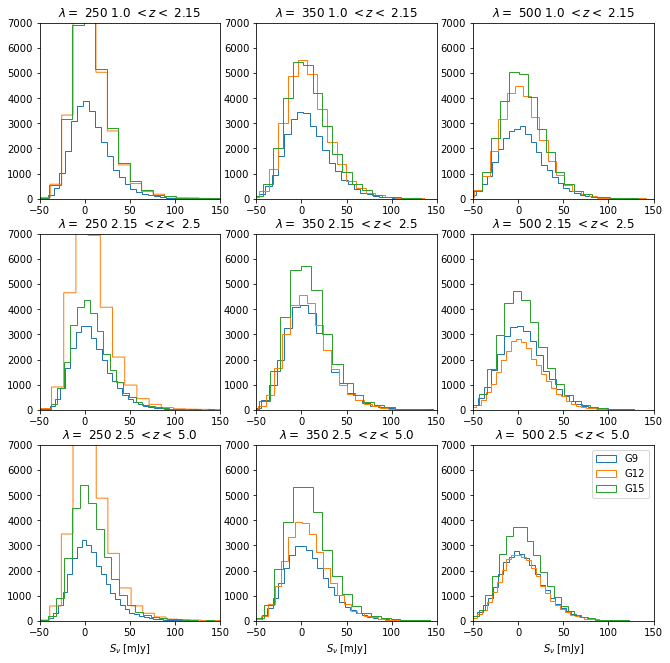

In [103]:
i = 1 
plt.figure(figsize=(11,11))
for idz, zbin in enumerate(zbins):
    for lambda_ in lambdas:
        plt.subplot(3,3,i)
        plt.title(r'$\lambda=$ '+str(lambda_) +' '+ str(zbin[0]) + r' $ < z < $ '+ str(zbin[1]))

        hist(anal.fluxes_bkd[lambda_]['G9'][idz], bins='knuth', histtype='step',label='G9')
        hist(anal.fluxes_bkd[lambda_]['G12'][idz], bins='knuth', histtype='step',label='G12')
        hist(anal.fluxes_bkd[lambda_]['G15'][idz], bins='knuth', histtype='step',label='G15')
#         print np.std(anal.fluxes_bkd[lambda_]['G9'][idz])/np.sqrt(anal.fluxes_bkd[lambda_]['G9'][idz].size)
        plt.xlim([-50,150])
        plt.ylim([0,7000])
        if i > 6:
            plt.xlabel(r'$S_{\nu}$ [mJy]')

        i+=1
plt.legend()

In [93]:
666.7*10**(-4/2.5) * 1e3

16746.74683887437

In [94]:
flux={}
for idz, zbin in enumerate(zbins):
    flux[idz]={}
    for lambda_ in lambdas:
            err, flux[idz][lambda_] = anal.GetTotBootstrapErrsFit2D(lambda_, idz, remove_mean=True, remove_max=15, nsim=500, nboot=2.)


utils.py:404: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)


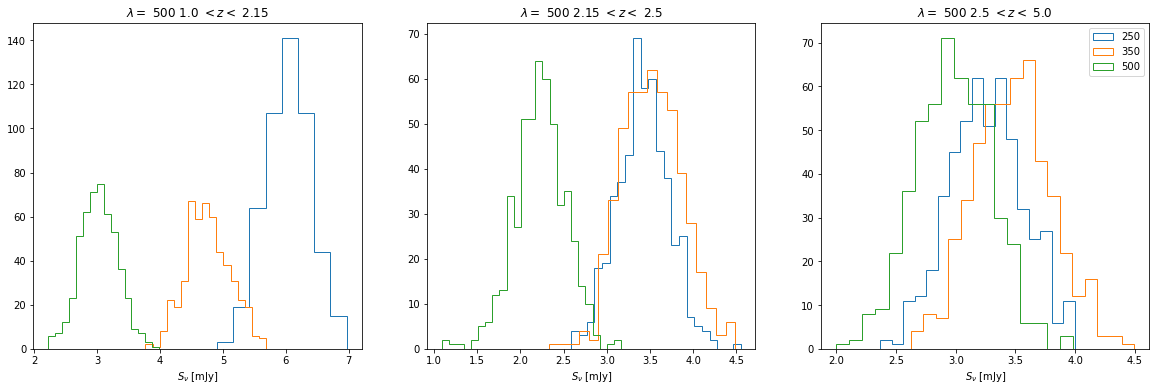

In [103]:
i = 1 
plt.figure(figsize=(20,6))
for idz, zbin in enumerate(zbins):
        plt.subplot(1,3,i)
        plt.title(r'$\lambda=$ '+str(lambda_) +' '+ str(zbin[0]) + r' $ < z < $ '+ str(zbin[1]))
        hist(flux[idz][250], bins='knuth', histtype='step', label='250')
        hist(flux[idz][350], bins='knuth', histtype='step', label='350')
        hist(flux[idz][500], bins='knuth', histtype='step', label='500')

#         print np.std(anal.fluxes_bkd[lambda_]['G9'][idz])/np.sqrt(anal.fluxes_bkd[lambda_]['G9'][idz].size)
#         plt.xlim([-50,150])
#         plt.ylim([0,7000])
#         if i > 6:
        plt.xlabel(r'$S_{\nu}$ [mJy]')

        i+=1
plt.legend()

In [ ]:
## SED plot #######

(0.001, 10.0)

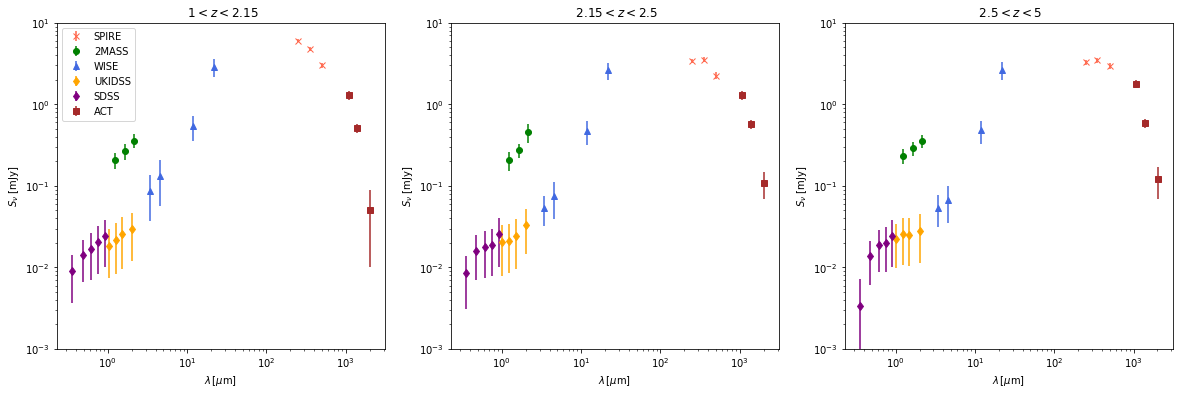

In [150]:
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.title(r' $1 < z < 2.15$')

# Hers
plt.errorbar(250, 6.02, yerr=0.27, color='tomato', fmt='x', label='SPIRE')
plt.errorbar(350, 4.78, yerr=0.26, color='tomato', fmt='x')
plt.errorbar(500, 3.04, yerr=0.22, color='tomato', fmt='x')

# 2MASS 
plt.errorbar((1.235), anal.medj2MASS[0], yerr=anal.errj2MASS[0], color='green', fmt='o', label='2MASS')
plt.errorbar((1.662), anal.medh2MASS[0], yerr=anal.errh2MASS[0], color='green', fmt='o')
plt.errorbar((2.159), anal.medk2MASS[0], yerr=anal.errk2MASS[0], color='green', fmt='o')

# WISE
plt.errorbar(3.4, anal.medw1[0], yerr=anal.errw1[0], color='royalblue', fmt='^', label='WISE')
plt.errorbar(4.6, anal.medw2[0], yerr=anal.errw2[0], color='royalblue', fmt='^')
plt.errorbar(12, anal.medw3[0], yerr=anal.errw3[0], color='royalblue', fmt='^')
plt.errorbar(22, anal.medw4[0], yerr=anal.errw4[0], color='royalblue', fmt='^')

# UKIDSS
plt.errorbar(1.02, anal.medyUKIDSS[0], yerr=anal.erryUKIDSS[0], color='orange', fmt='d', label='UKIDSS')
plt.errorbar(1.25, anal.medjUKIDSS[0], yerr=anal.errjUKIDSS[0], color='orange', fmt='d')
plt.errorbar(1.49, anal.medhUKIDSS[0], yerr=anal.errhUKIDSS[0], color='orange', fmt='d')
plt.errorbar(2.03, anal.medkUKIDSS[0], yerr=anal.errkUKIDSS[0], color='orange', fmt='d')

# SDSS
plt.errorbar(0.35, anal.medu[0], yerr=anal.erru[0], color='purple', fmt='d', label='SDSS')
plt.errorbar(0.48, anal.medg[0], yerr=anal.errg[0], color='purple', fmt='d')
plt.errorbar(0.62, anal.medr[0], yerr=anal.errr[0], color='purple', fmt='d')
plt.errorbar(0.76, anal.medi[0], yerr=anal.erri[0], color='purple', fmt='d')
plt.errorbar(0.91, anal.medz[0], yerr=anal.errz[0], color='purple', fmt='d')

#ACT
plt.errorbar(GHz_to_lambda(148), 0.05, yerr=0.04, color='brown', fmt='s', label='ACT')
plt.errorbar(GHz_to_lambda(218), 0.51,  yerr=0.07, color='brown', fmt='s')
plt.errorbar(GHz_to_lambda(277), 1.3,  yerr=0.16, color='brown', fmt='s')

plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel(r'$\lambda \, [\mu$m]')
plt.ylabel(r'$S_{\nu}$ [mJy]')
plt.ylim([1e-3,1e1])

plt.subplot(132)
plt.title(r' $2.15 < z < 2.5$')

# Hers
plt.errorbar(250, 3.40, yerr=0.22, color='tomato', fmt='x', label='SPIRE')
plt.errorbar(350, 3.53, yerr=0.24, color='tomato', fmt='x')
plt.errorbar(500, 2.25, yerr=0.23, color='tomato', fmt='x')

# 2MASS 
plt.errorbar((1.235), anal.medj2MASS[1], yerr=anal.errj2MASS[1], color='green', fmt='o', label='2MASS')
plt.errorbar((1.662), anal.medh2MASS[1], yerr=anal.errh2MASS[1], color='green', fmt='o')
plt.errorbar((2.159), anal.medk2MASS[1], yerr=anal.errk2MASS[1], color='green', fmt='o')

# WISE
plt.errorbar(3.4, anal.medw1[1], yerr=anal.errw1[1], color='royalblue', fmt='^', label='WISE')
plt.errorbar(4.6, anal.medw2[1], yerr=anal.errw2[1], color='royalblue', fmt='^')
plt.errorbar(12, anal.medw3[1], yerr=anal.errw3[1], color='royalblue', fmt='^')
plt.errorbar(22, anal.medw4[1], yerr=anal.errw4[1], color='royalblue', fmt='^')

# UKIDSS
plt.errorbar(1.02, anal.medyUKIDSS[1], yerr=anal.erryUKIDSS[1], color='orange', fmt='d', label='UKIDSS')
plt.errorbar(1.25, anal.medjUKIDSS[1], yerr=anal.errjUKIDSS[1], color='orange', fmt='d')
plt.errorbar(1.49, anal.medhUKIDSS[1], yerr=anal.errhUKIDSS[1], color='orange', fmt='d')
plt.errorbar(2.03, anal.medkUKIDSS[1], yerr=anal.errkUKIDSS[1], color='orange', fmt='d')

# SDSS
plt.errorbar(0.35, anal.medu[1], yerr=anal.erru[1], color='purple', fmt='d', label='SDSS')
plt.errorbar(0.48, anal.medg[1], yerr=anal.errg[1], color='purple', fmt='d')
plt.errorbar(0.62, anal.medr[1], yerr=anal.errr[1], color='purple', fmt='d')
plt.errorbar(0.76, anal.medi[1], yerr=anal.erri[1], color='purple', fmt='d')
plt.errorbar(0.91, anal.medz[1], yerr=anal.errz[1], color='purple', fmt='d')

#ACT
plt.errorbar(GHz_to_lambda(148), 0.11, yerr=0.04, color='brown', fmt='s', label='ACT')
plt.errorbar(GHz_to_lambda(218), 0.57,  yerr=0.07, color='brown', fmt='s')
plt.errorbar(GHz_to_lambda(277), 1.3,  yerr=0.17, color='brown', fmt='s')

plt.xscale('log')
plt.yscale('log')
# plt.legend(loc='best')
plt.xlabel(r'$\lambda \, [\mu$m]')
plt.ylabel(r'$S_{\nu}$ [mJy]')
plt.ylim([1e-3,1e1])

plt.subplot(133)
plt.title(r' $2.5 < z < 5$')

# Hers
plt.errorbar(250, 3.28, yerr=0.23, color='tomato', fmt='x', label='SPIRE')
plt.errorbar(350, 3.46, yerr=0.23, color='tomato', fmt='x')
plt.errorbar(500, 2.96, yerr=0.24, color='tomato', fmt='x')

# 2MASS 
plt.errorbar((1.235), anal.medj2MASS[2], yerr=anal.errj2MASS[2], color='green', fmt='o', label='2MASS')
plt.errorbar((1.662), anal.medh2MASS[2], yerr=anal.errh2MASS[2], color='green', fmt='o')
plt.errorbar((2.159), anal.medk2MASS[2], yerr=anal.errk2MASS[2], color='green', fmt='o')

# WISE
plt.errorbar(3.4, anal.medw1[2], yerr=anal.errw1[2], color='royalblue', fmt='^', label='WISE')
plt.errorbar(4.6, anal.medw2[2], yerr=anal.errw2[2], color='royalblue', fmt='^')
plt.errorbar(12, anal.medw3[2], yerr=anal.errw3[2], color='royalblue', fmt='^')
plt.errorbar(22, anal.medw4[2], yerr=anal.errw4[2], color='royalblue', fmt='^')

# UKIDSS
plt.errorbar(1.02, anal.medyUKIDSS[2], yerr=anal.erryUKIDSS[2], color='orange', fmt='d', label='UKIDSS')
plt.errorbar(1.25, anal.medjUKIDSS[2], yerr=anal.errjUKIDSS[2], color='orange', fmt='d')
plt.errorbar(1.49, anal.medhUKIDSS[2], yerr=anal.errhUKIDSS[2], color='orange', fmt='d')
plt.errorbar(2.03, anal.medkUKIDSS[2], yerr=anal.errkUKIDSS[2], color='orange', fmt='d')

# SDSS
plt.errorbar(0.35, anal.medu[2], yerr=anal.erru[2], color='purple', fmt='d', label='SDSS')
plt.errorbar(0.48, anal.medg[2], yerr=anal.errg[2], color='purple', fmt='d')
plt.errorbar(0.62, anal.medr[2], yerr=anal.errr[2], color='purple', fmt='d')
plt.errorbar(0.76, anal.medi[2], yerr=anal.erri[2], color='purple', fmt='d')
plt.errorbar(0.91, anal.medz[2], yerr=anal.errz[2], color='purple', fmt='d')

#ACT
plt.errorbar(GHz_to_lambda(148), 0.12, yerr=0.05, color='brown', fmt='s', label='ACT')
plt.errorbar(GHz_to_lambda(218), 0.59,  yerr=0.07, color='brown', fmt='s')
plt.errorbar(GHz_to_lambda(277), 1.8,  yerr=0.17, color='brown', fmt='s')

plt.xlabel(r'$\lambda \, [\mu$m]')
plt.ylabel(r'$S_{\nu}$ [mJy]')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-3,1e1]) 

In [134]:
lambda_to_GHz(0.76)

394736.8421052632

(0.007, 8)

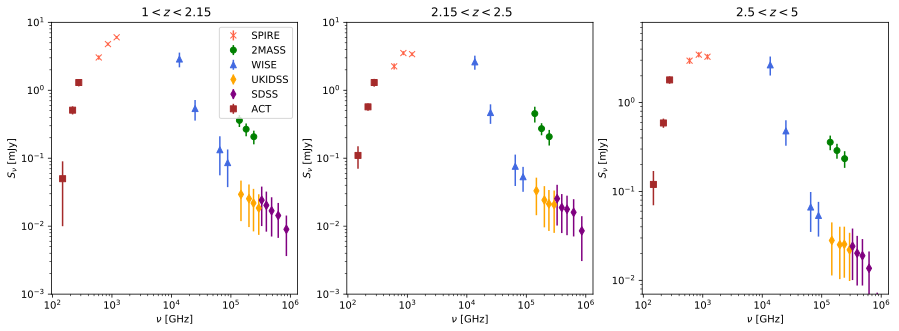

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title(r' $1 < z < 2.15$')

# Hers
plt.errorbar(lambda_to_GHz(250), 6.02, yerr=0.27, color='tomato', fmt='x', label='SPIRE')
plt.errorbar(lambda_to_GHz(350), 4.78, yerr=0.26, color='tomato', fmt='x')
plt.errorbar(lambda_to_GHz(500), 3.04, yerr=0.22, color='tomato', fmt='x')

# 2MASS 
plt.errorbar(lambda_to_GHz(1.235), anal.medj2MASS[0], yerr=anal.errj2MASS[0], color='green', fmt='o', label='2MASS')
plt.errorbar(lambda_to_GHz(1.662), anal.medh2MASS[0], yerr=anal.errh2MASS[0], color='green', fmt='o')
plt.errorbar(lambda_to_GHz(2.159), anal.medk2MASS[0], yerr=anal.errk2MASS[0], color='green', fmt='o')

# WISE
plt.errorbar(lambda_to_GHz(3.4), anal.medw1[0], yerr=anal.errw1[0], color='royalblue', fmt='^', label='WISE')
plt.errorbar(lambda_to_GHz(4.6), anal.medw2[0], yerr=anal.errw2[0], color='royalblue', fmt='^')
plt.errorbar(lambda_to_GHz(12), anal.medw3[0], yerr=anal.errw3[0], color='royalblue', fmt='^')
plt.errorbar(lambda_to_GHz(22), anal.medw4[0], yerr=anal.errw4[0], color='royalblue', fmt='^')

# UKIDSS
plt.errorbar(lambda_to_GHz(1.02), anal.medyUKIDSS[0], yerr=anal.erryUKIDSS[0], color='orange', fmt='d', label='UKIDSS')
plt.errorbar(lambda_to_GHz(1.25), anal.medjUKIDSS[0], yerr=anal.errjUKIDSS[0], color='orange', fmt='d')
plt.errorbar(lambda_to_GHz(1.49), anal.medhUKIDSS[0], yerr=anal.errhUKIDSS[0], color='orange', fmt='d')
plt.errorbar(lambda_to_GHz(2.03), anal.medkUKIDSS[0], yerr=anal.errkUKIDSS[0], color='orange', fmt='d')

# SDSS
plt.errorbar(lambda_to_GHz(0.35), anal.medu[0], yerr=anal.erru[0], color='purple', fmt='d', label='SDSS')
plt.errorbar(lambda_to_GHz(0.48), anal.medg[0], yerr=anal.errg[0], color='purple', fmt='d')
plt.errorbar(lambda_to_GHz(0.62), anal.medr[0], yerr=anal.errr[0], color='purple', fmt='d')
plt.errorbar(lambda_to_GHz(0.76), anal.medi[0], yerr=anal.erri[0], color='purple', fmt='d')
plt.errorbar(lambda_to_GHz(0.91), anal.medz[0], yerr=anal.errz[0], color='purple', fmt='d')

#ACT
plt.errorbar((148), 0.05, yerr=0.04, color='brown', fmt='s', label='ACT')
plt.errorbar((218), 0.51,  yerr=0.07, color='brown', fmt='s')
plt.errorbar((277), 1.3,  yerr=0.16, color='brown', fmt='s')

plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel(r'$S_{\nu}$ [mJy]')
plt.ylim([1e-3,1e1])

plt.subplot(132)
plt.title(r' $2.15 < z < 2.5$')

# Hers
plt.errorbar(lambda_to_GHz(250), 3.40, yerr=0.22, color='tomato', fmt='x', label='SPIRE')
plt.errorbar(lambda_to_GHz(350), 3.53, yerr=0.24, color='tomato', fmt='x')
plt.errorbar(lambda_to_GHz(500), 2.25, yerr=0.23, color='tomato', fmt='x')

# 2MASS 
plt.errorbar(lambda_to_GHz(1.235), anal.medj2MASS[1], yerr=anal.errj2MASS[1], color='green', fmt='o', label='2MASS')
plt.errorbar(lambda_to_GHz(1.662), anal.medh2MASS[1], yerr=anal.errh2MASS[1], color='green', fmt='o')
plt.errorbar(lambda_to_GHz(2.159), anal.medk2MASS[1], yerr=anal.errk2MASS[1], color='green', fmt='o')

# WISE
plt.errorbar(lambda_to_GHz(3.4), anal.medw1[1], yerr=anal.errw1[1], color='royalblue', fmt='^', label='WISE')
plt.errorbar(lambda_to_GHz(4.6), anal.medw2[1], yerr=anal.errw2[1], color='royalblue', fmt='^')
plt.errorbar(lambda_to_GHz(12), anal.medw3[1], yerr=anal.errw3[1], color='royalblue', fmt='^')
plt.errorbar(lambda_to_GHz(22), anal.medw4[1], yerr=anal.errw4[1], color='royalblue', fmt='^')

# UKIDSS
plt.errorbar(lambda_to_GHz(1.02), anal.medyUKIDSS[1], yerr=anal.erryUKIDSS[1], color='orange', fmt='d', label='UKIDSS')
plt.errorbar(lambda_to_GHz(1.25), anal.medjUKIDSS[1], yerr=anal.errjUKIDSS[1], color='orange', fmt='d')
plt.errorbar(lambda_to_GHz(1.49), anal.medhUKIDSS[1], yerr=anal.errhUKIDSS[1], color='orange', fmt='d')
plt.errorbar(lambda_to_GHz(2.03), anal.medkUKIDSS[1], yerr=anal.errkUKIDSS[1], color='orange', fmt='d')

# SDSS
plt.errorbar(lambda_to_GHz(0.35), anal.medu[1], yerr=anal.erru[1], color='purple', fmt='d', label='SDSS')
plt.errorbar(lambda_to_GHz(0.48), anal.medg[1], yerr=anal.errg[1], color='purple', fmt='d')
plt.errorbar(lambda_to_GHz(0.62), anal.medr[1], yerr=anal.errr[1], color='purple', fmt='d')
plt.errorbar(lambda_to_GHz(0.76), anal.medi[1], yerr=anal.erri[1], color='purple', fmt='d')
plt.errorbar(lambda_to_GHz(0.91), anal.medz[1], yerr=anal.errz[1], color='purple', fmt='d')

#ACT
plt.errorbar((148), 0.11, yerr=0.04, color='brown', fmt='s', label='ACT')
plt.errorbar((218), 0.57,  yerr=0.07, color='brown', fmt='s')
plt.errorbar((277), 1.3,  yerr=0.17, color='brown', fmt='s')

plt.xscale('log')
plt.yscale('log')
# plt.legend(loc='best')
plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel(r'$S_{\nu}$ [mJy]')
plt.ylim([1e-3,1e1])

plt.subplot(133)
plt.title(r' $2.5 < z < 5$')

# Hers
plt.errorbar(lambda_to_GHz(250), 3.28, yerr=0.23, color='tomato', fmt='x', label='SPIRE')
plt.errorbar(lambda_to_GHz(350), 3.46, yerr=0.23, color='tomato', fmt='x')
plt.errorbar(lambda_to_GHz(500), 2.96, yerr=0.24, color='tomato', fmt='x')

# 2MASS 
plt.errorbar(lambda_to_GHz(1.235), anal.medj2MASS[2], yerr=anal.errj2MASS[2], color='green', fmt='o', label='2MASS')
plt.errorbar(lambda_to_GHz(1.662), anal.medh2MASS[2], yerr=anal.errh2MASS[2], color='green', fmt='o')
plt.errorbar(lambda_to_GHz(2.159), anal.medk2MASS[2], yerr=anal.errk2MASS[2], color='green', fmt='o')

# WISE
plt.errorbar(lambda_to_GHz(3.4), anal.medw1[2], yerr=anal.errw1[2], color='royalblue', fmt='^', label='WISE')
plt.errorbar(lambda_to_GHz(4.6), anal.medw2[2], yerr=anal.errw2[2], color='royalblue', fmt='^')
plt.errorbar(lambda_to_GHz(12), anal.medw3[2], yerr=anal.errw3[2], color='royalblue', fmt='^')
plt.errorbar(lambda_to_GHz(22), anal.medw4[2], yerr=anal.errw4[2], color='royalblue', fmt='^')

# UKIDSS
plt.errorbar(lambda_to_GHz(1.02), anal.medyUKIDSS[2], yerr=anal.erryUKIDSS[2], color='orange', fmt='d', label='UKIDSS')
plt.errorbar(lambda_to_GHz(1.25), anal.medjUKIDSS[2], yerr=anal.errjUKIDSS[2], color='orange', fmt='d')
plt.errorbar(lambda_to_GHz(1.49), anal.medhUKIDSS[2], yerr=anal.errhUKIDSS[2], color='orange', fmt='d')
plt.errorbar(lambda_to_GHz(2.03), anal.medkUKIDSS[2], yerr=anal.errkUKIDSS[2], color='orange', fmt='d')

# SDSS
plt.errorbar(lambda_to_GHz(0.35), anal.medu[2], yerr=anal.erru[2], color='purple', fmt='d', label='SDSS')
plt.errorbar(lambda_to_GHz(0.48), anal.medg[2], yerr=anal.errg[2], color='purple', fmt='d')
plt.errorbar(lambda_to_GHz(0.62), anal.medr[2], yerr=anal.errr[2], color='purple', fmt='d')
plt.errorbar(lambda_to_GHz(0.76), anal.medi[2], yerr=anal.erri[2], color='purple', fmt='d')
plt.errorbar(lambda_to_GHz(0.91), anal.medz[2], yerr=anal.errz[2], color='purple', fmt='d')
 
#ACT
plt.errorbar((148), 0.12, yerr=0.05, color='brown', fmt='s', label='ACT')
plt.errorbar((218), 0.59,  yerr=0.07, color='brown', fmt='s')
plt.errorbar((277), 1.8,  yerr=0.17, color='brown', fmt='s')

plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel(r'$S_{\nu}$ [mJy]')
plt.xscale('log')
plt.yscale('log')
plt.ylim([7e-3,8])

In [169]:
(4+6+7.6)/3

5.866666666666667

(0.007, 8)

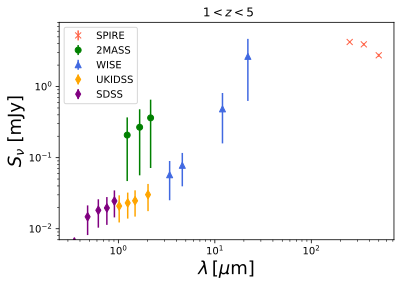

In [14]:
# plt.figure(figsize=(20,6))
plt.title(r' $1 < z < 5$')

# Hers
plt.errorbar(250, 4.23, yerr=0.13, color='tomato', fmt='x', label='SPIRE')
plt.errorbar(350, 3.92, yerr=0.15, color='tomato', fmt='x')
plt.errorbar(500, 2.75, yerr=0.13, color='tomato', fmt='x')

# 2MASS 
plt.errorbar((1.235), anal.medj2MASS['all'], yerr=[(anal.loj2MASS['all'],anal.hij2MASS['all'])], color='green', fmt='o', label='2MASS')
plt.errorbar((1.662), anal.medh2MASS['all'], yerr=[(anal.loh2MASS['all'],anal.hih2MASS['all'])], color='green', fmt='o')
plt.errorbar((2.159), anal.medk2MASS['all'], yerr=[(anal.lok2MASS['all'],anal.hik2MASS['all'])], color='green', fmt='o')

# WISE
plt.errorbar(3.4, anal.medw1['all'], yerr=[(anal.low1['all'],anal.hiw1['all'])], color='royalblue', fmt='^', label='WISE')
plt.errorbar(4.6, anal.medw2['all'], yerr=[(anal.low2['all'],anal.hiw2['all'])], color='royalblue', fmt='^')
plt.errorbar(12, anal.medw3['all'], yerr=[(anal.low3['all'],anal.hiw3['all'])], color='royalblue', fmt='^')
plt.errorbar(22, anal.medw4['all'], yerr=[(anal.low4['all'],anal.hiw4['all'])], color='royalblue', fmt='^')

# UKIDSS
plt.errorbar(1.02, anal.medyUKIDSS['all'], yerr=[(anal.loyUKIDSS['all'],anal.hiyUKIDSS['all'])], color='orange', fmt='d', label='UKIDSS')
plt.errorbar(1.25, anal.medjUKIDSS['all'], yerr=[(anal.lojUKIDSS['all'],anal.hijUKIDSS['all'])], color='orange', fmt='d')
plt.errorbar(1.49, anal.medhUKIDSS['all'], yerr=[(anal.lohUKIDSS['all'],anal.hihUKIDSS['all'])], color='orange', fmt='d')
plt.errorbar(2.03, anal.medkUKIDSS['all'], yerr=[(anal.lokUKIDSS['all'],anal.hikUKIDSS['all'])], color='orange', fmt='d')

# SDSS
plt.errorbar(0.35, anal.medu['all'], yerr=[(anal.lou['all'],anal.hiu['all'])], color='purple', fmt='d', label='SDSS')
plt.errorbar(0.48, anal.medg['all'], yerr=[(anal.log['all'],anal.hig['all'])], color='purple', fmt='d')
plt.errorbar(0.62, anal.medr['all'], yerr=[(anal.lor['all'],anal.hir['all'])], color='purple', fmt='d')
plt.errorbar(0.76, anal.medi['all'], yerr=[(anal.loi['all'],anal.hii['all'])], color='purple', fmt='d')
plt.errorbar(0.91, anal.medz['all'], yerr=[(anal.loz['all'],anal.hiz['all'])], color='purple', fmt='d')

plt.xscale('log')
plt.yscale('log')

plt.legend(loc='best')
plt.xlabel(r'$\lambda \, [\mu$m]', size=18)
plt.ylabel(r'$S_{\nu}$ [mJy]', size=18)
plt.ylim([7e-3,8])

In [106]:
anal.GetFluxesCats('all')

utils.py:49: RuntimeWarning: overflow encountered in double_scalars
  return 171.787 * 10**(-mags/2.5) * 1e3
utils.py:51: RuntimeWarning: overflow encountered in double_scalars
  return 31.674 * 10**(-mags/2.5) * 1e3
utils.py:53: RuntimeWarning: overflow encountered in double_scalars
  return 8.363 * 10**(-mags/2.5) * 1e3


0.0247109159613
0.00899056426721
0.00899056426721
0.00362796191452
0.0274322014333


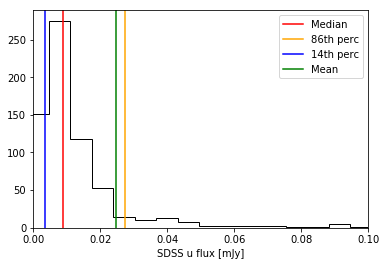

In [119]:
print np.mean(anal.uflux[0])
print np.median(anal.uflux[0])
print np.percentile(anal.uflux[0], 50)
print np.percentile(anal.uflux[0], 14)
print np.percentile(anal.uflux[0], 86)
hist(anal.uflux[0], bins=100, histtype='step', color='k')
plt.xlim([0.,0.1])
plt.axvline( np.percentile(anal.uflux[0], 50),color='r', label='Median')
plt.axvline( np.percentile(anal.uflux[0], 86),color='orange', label='86th perc')
plt.axvline( np.percentile(anal.uflux[0], 14),color='blue', label='14th perc')
plt.axvline( np.mean(anal.uflux[0]),color='g', label='Mean')
plt.xlabel('SDSS u flux [mJy]')
plt.legend()

In [7]:
anal.GetFluxesCats('all')
anal.PrintFluxesCats('all')

utils.py:49: RuntimeWarning: overflow encountered in double_scalars
  return 171.787 * 10**(-mags/2.5) * 1e3
utils.py:51: RuntimeWarning: overflow encountered in double_scalars
  return 31.674 * 10**(-mags/2.5) * 1e3
utils.py:53: RuntimeWarning: overflow encountered in double_scalars
  return 8.363 * 10**(-mags/2.5) * 1e3


~~~~~~~~~~ WISE ~~~~~~~~~~~~~~~
........ 1.0 < z < 2.15 ........
W1: 0.0860^{+0.1684}_{-0.0485}
W2: 0.1332^{+0.2875}_{-0.0772}
W3: 0.5379^{+-1.5369}_{-0.1805}
W4: 2.8785^{+1.5628}_{-0.7027}
- - - - - - - - - - - - - - - -
........ 2.15 < z < 2.5 ........
W1: 0.0533^{+0.0515}_{-0.0213}
W2: 0.0761^{+0.0821}_{-0.0371}
W3: 0.4702^{+-1.8923}_{-0.1503}
W4: 2.6180^{+1.0461}_{-0.6137}
- - - - - - - - - - - - - - - -
........ 2.5 < z < 5.0 ........
W1: 0.0537^{+0.0730}_{-0.0227}
W2: 0.0668^{+0.0923}_{-0.0318}
W3: 0.4798^{+-1.8697}_{-0.1530}
W4: 2.6544^{+1.1259}_{-0.6406}
- - - - - - - - - - - - - - - -

~~~~~~~~~ 2MASS ~~~~~~~~~~~~~~~
........ 1.0 < z < 2.15 ........
J: 0.2072^{+0.0876}_{-0.0472}
H: 0.2675^{+0.1148}_{-0.0571}
K: 0.3604^{+0.1444}_{-0.0721}
- - - - - - - - - - - - - - - -
........ 2.15 < z < 2.5 ........
J: 0.2074^{+0.1277}_{-0.0536}
H: 0.2725^{+0.1418}_{-0.0550}
K: 0.4537^{+0.0282}_{-0.1188}
- - - - - - - - - - - - - - - -
........ 2.5 < z < 5.0 ........
J: 0.2340^{+0.1403}_{-0.

250 1.0 2.15 6.01955061834


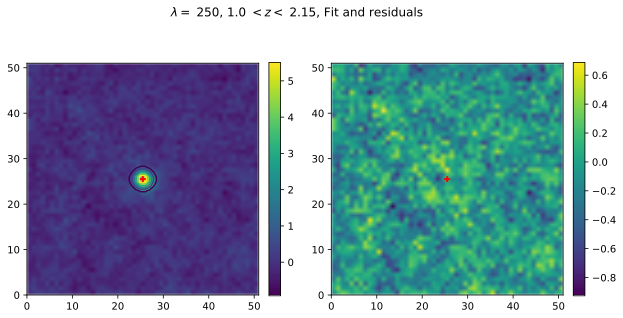

In [8]:
plt.figure(figsize=(10,10))
for idz, zbin in enumerate(zbins[:1]):
    for lambda_ in lambdas[:1]:
            p = anal.GaussFitTot(lambda_, idz, remove_max=15, remove_mean=True, plot=True)
            print lambda_, zbin[0], zbin[1], p.amplitude.value

In [20]:
plt.figure(figsize=(10,10))
for idz, zbin in enumerate(zbins[:1]):
    for lambda_ in lambdas[2:3]:
            p = anal.GaussFitTot(lambda_, idz, remove_max=15, remove_mean=True, plot=False)
            print lambda_, zbin[0], zbin[1], p.amplitude.value


500 1.0 2.15 3.04457259032


In [180]:
print 'K_S : %.3f mJy' %TwoMASSMag2mJy(14.3, 'K_S')
print 'H   : %.3f mJy' %TwoMASSMag2mJy(15.1, 'H')
print 'J   : %.3f mJy' %TwoMASSMag2mJy(15.8, 'J')


K_S : 1.270 mJy
H   : 0.934 mJy
J   : 0.763 mJy


In [172]:
plt.figure(figsize=(10,10))
for idz, zbin in enumerate(zbins):
    for lambda_ in lambdas:
            p = anal.GaussFitTot(lambda_, idz, remove_max=15, remove_mean=True, plot=False)
            print lambda_, zbin[0], zbin[1], p.amplitude.value


250 1.0 2.15 6.0834687098
350 1.0 2.15 4.87701527494
500 1.0 2.15 3.10948148568
250 2.15 2.5 3.36312510259
350 2.15 2.5 3.55242641965
500 2.15 2.5 2.25245508935
250 2.5 5.0 3.39826619481
350 2.5 5.0 3.44026961128
500 2.5 5.0 2.98503797596


0.14121618956
0.0860432809856
0.0860432809856
0.037499792706
0.254437767096


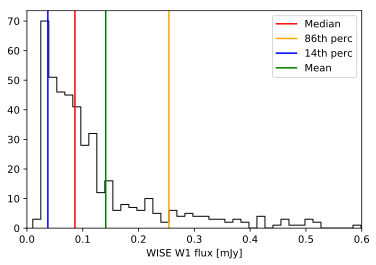

In [12]:
print np.mean(anal.w1mag[0])
print np.median(anal.w1mag[0])
print np.percentile(anal.w1mag[0], 50)
print np.percentile(anal.w1mag[0], 14)
print np.percentile(anal.w1mag[0], 86)
hist(anal.w1mag[0], bins=100, histtype='step', color='k')
plt.xlim([0.,0.6])
plt.axvline( np.percentile(anal.w1mag[0], 50),color='r', label='Median')
plt.axvline( np.percentile(anal.w1mag[0], 86),color='orange', label='86th perc')
plt.axvline( np.percentile(anal.w1mag[0], 14),color='blue', label='14th perc')
plt.axvline( np.mean(anal.w1mag[0]),color='g', label='Mean')
plt.xlabel('WISE W1 flux [mJy]')
plt.legend()

In [17]:
240/60.

4.0

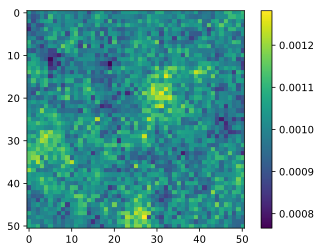

In [9]:
plt.imshow(anal.bkd[250]['G12'][0]); plt.colorbar()

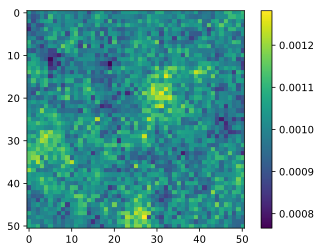

In [10]:
plt.imshow(anal.bkd[250]['G12'][0]); plt.colorbar()

250 1.0 2.15 6.01955061834


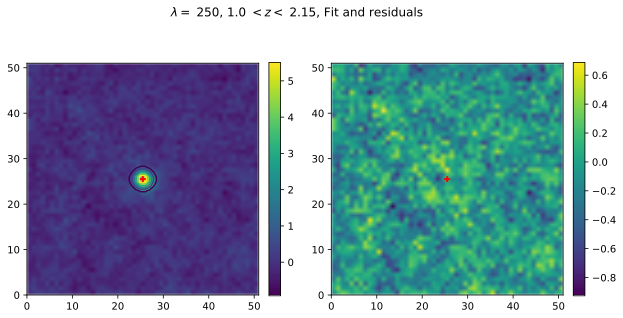

In [11]:
plt.figure(figsize=(10,10))
for idz, zbin in enumerate(zbins[:1]):
    for lambda_ in lambdas[:1]:
            p = anal.GaussFitTot(lambda_, idz, remove_max=15, remove_mean=True, plot=True)
            print lambda_, zbin[0], zbin[1], p.amplitude.value

(714, 40, 40)
(514, 40, 40)


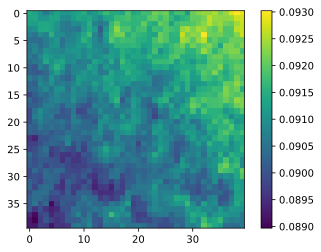

In [71]:
x = anal.cuts[90]['G15'][0].copy()
print x.shape
for _ in xrange(200):
    x = np.delete(x, np.argmax(np.mean(x, axis=(1,2))), axis=0)

print x.shape

plt.imshow(x.mean(0)*1e-9/(4.05e-8))
plt.colorbar()
plt.savefig('/Users/fbianchini/Research/StacktSZ/akari.pdf')

814.398978859


(array([  8.14398979e+02,  -4.50615392e+01,   4.23721659e+01,
          2.68929033e+00,   4.16308231e+01,   1.76296832e+01,
          3.63333628e+03]),
 array([[  1.44179781e+06,  -9.15598512e+04,   3.33632732e+04,
           1.11124879e+00,   3.13293270e+04,  -2.30545053e+00,
          -2.31436375e+02],
        [ -9.15598512e+04,   5.85600495e+03,  -2.13385548e+03,
          -3.36016090e-01,  -2.01778591e+03,   1.48182951e-01,
           1.86704951e+01],
        [  3.33632732e+04,  -2.13385548e+03,   7.78517010e+02,
           1.07713124e-01,   7.35484180e+02,  -3.89902340e-02,
          -6.80329100e+00],
        [  1.11124879e+00,  -3.36016090e-01,   1.07713124e-01,
           2.54262443e-02,   1.46928241e-01,  -2.16941116e-04,
          -2.51891423e-01],
        [  3.13293270e+04,  -2.01778591e+03,   7.35484180e+02,
           1.46928241e-01,   7.00856308e+02,  -4.77944664e-02,
          -8.86716952e+00],
        [ -2.30545053e+00,   1.48182951e-01,  -3.89902340e-02,
          -2.16

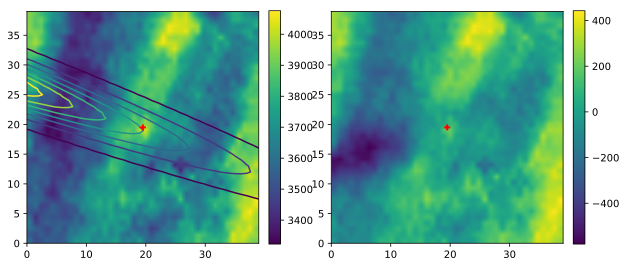

In [10]:

anal.FitGauss2D(90, 'G12', 0, remove_mean=False, remove_max=600, plot=True)

In [13]:
from stackocat import QSOcat
from read_cats import GetSDSSCat
qso_cat = QSOcat(GetSDSSCat(cats=['DR7', 'DR12'], discard_FIRST=True, z_DR12='Z_PIPE'), zbins)


	...z-bin : 1.0 < z < 2.15
	...z-bin : 2.15 < z < 2.5
	...z-bin : 2.5 < z < 5.0


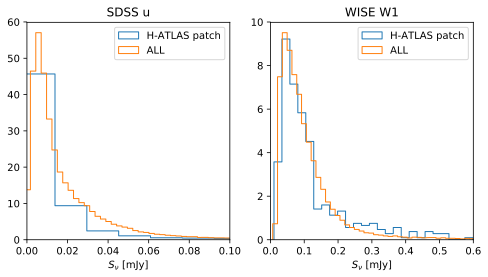

In [48]:
plt.figure(figsize=(8,4))

plt.subplot(121)
plt.title('SDSS u')
hist(anal.uflux[0], 'knuth', histtype='step', label='H-ATLAS patch', normed=True)
hist(qso_cat.uflux[0], 'knuth', histtype='step', label='ALL', normed=True)
plt.legend()
plt.xlabel(r'$S_{\nu}$ [mJy]')
# plt.ylabel(r'$$ [mJy]')
plt.xlim([0,0.1])

plt.subplot(122)
plt.title('WISE W1')
hist(anal.w1mag[0], 'knuth', histtype='step', label='H-ATLAS patch', normed=True)
hist(qso_cat.w1mag[0], 'knuth', histtype='step', label='ALL', normed=True)
plt.legend()
plt.xlabel(r'$S_{\nu}$ [mJy]')
# plt.ylabel(r'$$ [mJy]')
plt.xlim([0,0.6])

plt.savefig('stack_all_1.pdf')

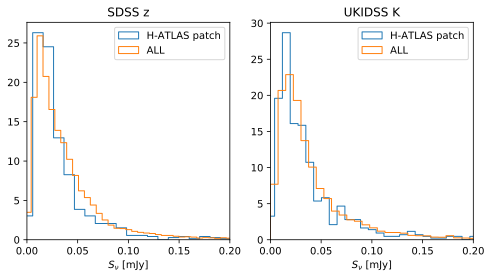

In [49]:
plt.figure(figsize=(8,4))

plt.subplot(121)
plt.title('SDSS z')
hist(anal.zflux[0], 'knuth', histtype='step', label='H-ATLAS patch', normed=True)
hist(qso_cat.zflux[0], 'knuth', histtype='step', label='ALL', normed=True)
plt.legend()
plt.xlabel(r'$S_{\nu}$ [mJy]')
# plt.ylabel(r'$$ [mJy]')
plt.xlim([0,0.2])

plt.subplot(122)
plt.title('UKIDSS K')
hist(anal.hfluxUKIDSS[0], 'knuth', histtype='step', label='H-ATLAS patch', normed=True)
hist(qso_cat.hfluxUKIDSS[0], 'knuth', histtype='step', label='ALL', normed=True)
plt.legend()
plt.xlabel(r'$S_{\nu}$ [mJy]')
# plt.ylabel(r'$$ [mJy]')
plt.xlim([0,.2])

plt.savefig('stack_all_2.pdf')

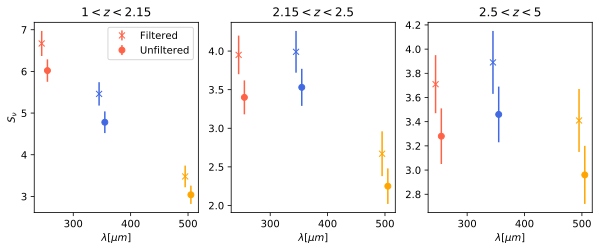

In [55]:
plt.figure(figsize=(10,3.5))

plt.subplot(131)
plt.title(r'$1 < z < 2.15$')
plt.errorbar(250-5, 6.67, yerr=0.30, color='tomato', fmt='x', label='Filtered')
plt.errorbar(250+5, 6.02, yerr=0.27, color='tomato', fmt='o', label='Unfiltered')
plt.errorbar(350-5, 5.46, yerr=0.28, color='royalblue', fmt='x')
plt.errorbar(350+5, 4.78, yerr=0.26, color='royalblue', fmt='o')
plt.errorbar(500-5, 3.48, yerr=0.26, color='orange', fmt='x')
plt.errorbar(500+5, 3.04, yerr=0.22, color='orange', fmt='o')
plt.legend()
plt.ylabel(r'$S_{\nu}$')
plt.xlabel(r'$\lambda [\mu m]$')

plt.subplot(132)
plt.title(r'$2.15 < z < 2.5$')
plt.errorbar(250-5, 3.95, yerr=0.25, color='tomato', fmt='x', label='Filtered')
plt.errorbar(250+5, 3.40, yerr=0.22, color='tomato', fmt='o', label='Unfiltered')
plt.errorbar(350-5, 3.99, yerr=0.27, color='royalblue', fmt='x')
plt.errorbar(350+5, 3.53, yerr=0.24, color='royalblue', fmt='o')
plt.errorbar(500-5, 2.67, yerr=0.29, color='orange', fmt='x')
plt.errorbar(500+5, 2.25, yerr=0.23, color='orange', fmt='o')
plt.xlabel(r'$\lambda [\mu m]$')

plt.subplot(133)
plt.title(r'$2.5 < z < 5$')
plt.errorbar(250-5, 3.71, yerr=0.24, color='tomato', fmt='x', label='Filtered')
plt.errorbar(350-5, 3.89, yerr=0.26, color='royalblue', fmt='x')
plt.errorbar(500-5, 3.41, yerr=0.26, color='orange', fmt='x')
plt.errorbar(250+5, 3.28, yerr=0.23, color='tomato', fmt='o', label='Unfiltered')
plt.errorbar(350+5, 3.46, yerr=0.23, color='royalblue', fmt='o')
plt.errorbar(500+5, 2.96, yerr=0.24, color='orange', fmt='o')
plt.xlabel(r'$\lambda [\mu m]$')

plt.savefig('H-ATLAS_Flux_comparison.pdf', bboxes_inches='tight')